## Importing libraries 

In [1]:
import os
import email
from email.policy import default
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import os
import re
import pandas as pd
from tqdm import tqdm
import random 
import numpy as np 
import re
import mailbox
from bs4 import BeautifulSoup
from sklearn.metrics import confusion_matrix ,accuracy_score,\
precision_recall_fscore_support, classification_report 
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')


2024-06-23 15:47:26.622059: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 15:47:26.622163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 15:47:26.791750: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# checking for gpu 

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-525b904f-294f-684a-0448-5a1d3f722c36)
GPU 1: Tesla T4 (UUID: GPU-38ce8d30-fb61-099d-3d2b-d04ca9b98375)


In [3]:
# installing packages
!pip freeze > kaggle_image_requirements.txt
!pip install tensorflow-text


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


## Getting phishing and ham data

In [4]:

def extract_message_bodies(text):
    # Split the text by the pattern that typically indicates the start of a new email
    messages = re.split(r'From r\s+', text)
    
    # Define a pattern to match the email headers which are typically followed by a blank line
    header_pattern = re.compile(r'(.*?)\n\n', re.DOTALL)
    
    phishing_messages_1 = []
    
    for message in messages:
        if not message.strip():
            continue
        
        # Find the header and remove it to get the body
        header_match = header_pattern.match(message)
        if header_match:
            body = message[header_match.end():].strip()
        else:
            # If no header match is found, treat the whole message as the body
            body = message.strip()
        
        phishing_messages_1.append(body)
    
    return phishing_messages_1


with open('/kaggle/input/fraudulent-email-corpus/fradulent_emails.txt',encoding='latin1') as f : 
    text=f.read()
# Extract message bodies
phishing_messages_1 = extract_message_bodies(text)

# Print the message bodies to verify
# for idx, body in enumerate(message_bodies):
#     print(f"Message {idx + 1} Body:\n{body}\n{'-'*50}\n")


In [186]:
print(f'{len(phishing_messages_1)} messages were extracted from file fradulent_emails.txt')

3976 messages were extracted from file fradulent_emails.txt


In [195]:
print('random message extracted from fradulent_emails.txt : \n','#'*100)
random.choice(phishing_messages_1)

random message extracted from fradulent_emails.txt : 
 ####################################################################################################


'--_e5c7bbbe-34c3-47c9-ab36-00df3bed2abf_\nContent-Type: text/plain; charset="Windows-1252"\nContent-Transfer-Encoding: quoted-printable\n\n\nMr. Koutaba Jean.The Account / Audit Manager,Banque De Habitat Au Burkina F=\naso(BHBF).Ouagadougou Burkina Faso.Dear Beloved,I presumed that all is well=\n with you and your family. Please let this do not be a surprise proposal to=\n you because i got your contact information from the international director=\ny in few weeks ago before i decided to contact you on this magintude and lu=\ncrative transaction for our future survival in life. Moreover, i have laid =\nall the solemn trust in you beforei decided to disclose this successful & c=\nonfidential transaction to you.As the Account / Audit Manager of our bank, =\ni have decided to contact you over this financial transaction worth the sum=\n of DOLLARS($5.500,000.00 ) for our success.This is an abandoned sum that b=\nelongs to one of our bank foreign customers who died along with his entire =\n

In [7]:
## getting ham data from email-spam-dataset-extended  dataset 

# Directory containing the email files
directory_ham = '/kaggle/input/email-spam-dataset-extended/ham_zipped/main_ham'

# List to store the message bodies
ham_messages = []

# Function to extract the body from an email message
def extract_body(msg):
    if msg.is_multipart():
        for part in msg.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get("Content-Disposition"))

            # Skip attachments and just get the plain text part
            if "attachment" not in content_disposition:
                if content_type == "text/plain":
                    return part.get_payload(decode=True).decode(errors='replace')
    else:
        return msg.get_payload(decode=True).decode(errors='replace')

# Function to read file content in binary mode and decode it
def read_file_in_binary(file_path):
    with open(file_path, 'rb') as file:
        return file.read()

# Function to decode the binary content using different encodings
def decode_content(binary_content):
    encodings = ['utf-8', 'latin1', 'ascii']
    for enc in encodings:
        try:
            return binary_content.decode(enc)
        except UnicodeDecodeError:
            continue
    return binary_content.decode('latin1', errors='replace')  # fallback to 'latin1' with replacement

# Read all files in the directory
for filename in os.listdir(directory_ham):
    file_path = os.path.join(directory_ham, filename)
    
    # Read the file content in binary mode
    binary_content = read_file_in_binary(file_path)
    
    # Decode the binary content
    email_content = decode_content(binary_content)
    
    # Parse the email content
    msg = email.message_from_string(email_content, policy=default)
    
    # Extract the message body
    body = extract_body(msg)
    
    # Append the body to the list
    if body:
        ham_messages.append(body)

# Now message_bodies contains all the email message bodies
print(f'Total ham messages extracted: {len(ham_messages)} from email-spam-dataset-extended/ham_zipped/main_ham')


Total ham messages extracted: 6947 email-spam-dataset-extended/ham_zipped/main_ham


In [194]:
print('a random message from ham messages extracted from email-spam-dataset-extended/ham_zipped/main_ham/ :\n','#'*100)
print(f'{random.choice(ham_messages)}')

a random message from ham messages extracted from email-spam-dataset-extended/ham_zipped/main_ham/ :
 ####################################################################################################
use Perl Daily Newsletter

In this issue:
    * The 2002 Perl Advent Calendar

+--------------------------------------------------------------------+
| The 2002 Perl Advent Calendar                                      |
|   posted by pudge on Sunday December 01, @16:15 (modules)          |
|   http://use.perl.org/article.pl?sid=02/12/01/2057219              |
+--------------------------------------------------------------------+

[0]2shortplanks writes "Doesn't December come round quickly? Announcing
the [1]third Perl Advent Calendar, the Advent calendar that features a
different Perl module each day of Advent, and a bonus module on Christmas
day. This year's improvements include each day having its own
mini-tutorial attached, and much better HTML."

Discuss this story at:
    http://u

In [9]:

## getting phishing data from email-spam-dataset-extended 

# Directory containing the email files
directory_spam = '/kaggle/input/email-spam-dataset-extended/spam_zipped/main_spam'

# List to store the message bodies
phishing_messages_2 = []

# Function to extract the body from an email message
def extract_body_from_spam(msg):
    if msg.is_multipart():
        for part in msg.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get("Content-Disposition"))

            # Skip attachments and just get the plain text part
            if "attachment" not in content_disposition:
                if content_type == "text/plain":
                    return part.get_payload(decode=True).decode(errors='replace')
    else:
        return msg.get_payload(decode=True).decode(errors='replace')

# Function to read file content in binary mode and decode it
def read_file_in_binary(file_path):
    with open(file_path, 'rb') as file:
        return file.read()

# Function to decode the binary content using different encodings
def decode_content(binary_content):
    encodings = ['utf-8', 'latin1', 'ascii']
    for enc in encodings:
        try:
            return binary_content.decode(enc)
        except UnicodeDecodeError:
            continue
    return binary_content.decode('latin1', errors='replace')  # fallback to 'latin1' with replacement

# Read all files in the directory
for filename in os.listdir(directory_spam):
    file_path = os.path.join(directory_spam, filename)
    
    # Read the file content in binary mode
    binary_content = read_file_in_binary(file_path)
    
    # Decode the binary content
    email_content = decode_content(binary_content)
    
    # Parse the email content
    msg = email.message_from_string(email_content, policy=default)
    
    # Extract the message body
    body = extract_body_from_spam(msg)
    
    # Append the body to the list
    if body:
        phishing_messages_2.append(body)

# Now message_bodies contains all the email message bodies
print(f'Total phishing messages extracted {len(phishing_messages_2)} from email-spam-dataset-extended/spam_zipped/main_spam')


Total phishing messages extracted 2293 from email-spam-dataset-extended/spam_zipped/main_spam


In [197]:
print('a random message from spam messages extracted from email-spam-dataset-extended/spam_zipped/main_spam/:\n','#'*100)
print(f'{random.choice(phishing_messages_2)}') 

a random message from spam messages extracted from email-spam-dataset-extended/spam_zipped/main_spam/:
 ####################################################################################################
 Non-Med Level Term 15-20 & 30 year with Return of Premium Rider!	
 It's Lucrative:	
 	 Commission so high we can't publish them
	
Annualization Available 	
Daily Commission by EFT 	
 It's Fast:	
 	 Qualifying policies processed in 4 days or company pays you
$100.00 	
Forms and Status from Internet 	
 It's Easy:	
 	 Non-medical underwriting (No Blood, No HOS, No Exam)* 	
 	 Ages 0-60	 $100,000	 
 	 Ages 61-70	 $50,000	 
 	 Easy To Complete Application 	
Fax Application to Home Office (No Need to Mail Original) 	
 888-574-9088	
Please fill out the form below for more information	 
Name:	  	
E-mail:	  	
Phone:	  	
City:	  	State:	  	 	
 	  	 	   	
 
 	
M14070PBL602
*Issuance of the policy based on answers to medical questions
We don't want anybody to receive our mailing who does not wis

In [11]:
## getting meassages from html like messages using beatiful soup 

def extract_message_body(message):
    soup = BeautifulSoup(message, 'html.parser')
    body = soup.get_text(separator='\n')
    return body.strip()

# List of messages
phishing_messages_3=[]
for ph_message in phishing_messages_2 : 
    phishing_messages_3.append(extract_message_body(ph_message))

In [199]:
print('a random phishing message from messages extracted from file in directory email-spam-dataset-extended/spam_zipped/main_spam:\n','#'*100)
print(f'{random.choice(phishing_messages_3)}')

a random phishing message from messages extracted from file in directory email-spam-dataset-extended/spam_zipped/main_spam:
 ####################################################################################################
1) Lose 22.5lbs in 3 weeks!
Flush Fat Away Forever! Free 30-Day Supply
http://www.adclick.ws/p.cfm?o=423&s=pk19

2) Introducing Chase Platinum for Students
With a 0% Introductory APR
http://www.adclick.ws/p.cfm?o=421&s=pk19

3) Access Your PC From Anywhere - Download Now
http://www.adclick.ws/p.cfm?o=425&s=pk19

Have a Wonderful day,
PrizeMama

------------------
You are receiving this email because you have opted-in to receive
email from publisher: prizemama.  To unsubscribe, click below:

http://u2.azoogle.com/?z=93-1090346-62lLC4
-- 
Irish Linux Users' Group Social Events: social@linux.ie
http://www.linux.ie/mailman/listinfo/social for (un)subscription information.
List maintainer: listmaster@linux.ie


In [17]:
## getting data from phishingemaildetection dataset 

# Path to the mbox file
legal_emails_file = '/kaggle/input/phishingemaildetection/emails-enron-legal-mails.mbox'

# List to store the message bodies
legal_emils = []

# Function to extract the body from an email message
def extract_body_from_legal(msg):
    if msg.is_multipart():
        for part in msg.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get("Content-Disposition"))

            # Skip attachments and just get the plain text part
            if "attachment" not in content_disposition:
                if content_type == "text/plain":
                    return part.get_payload(decode=True).decode('utf-8', errors='replace')
    else:
        return msg.get_payload(decode=True).decode('utf-8', errors='replace')

# Open the mbox file
mbox = mailbox.mbox(legal_emails_file)

# Iterate through each message in the mbox file
for msg in mbox:
    # Extract the message body
    body = extract_body_from_legal(msg)
    
    # Append the body to the list
    if body:
        legal_emils.append(body)

# Now message_bodies contains all the email message bodies
print(f'Total benign messages extracted from  emails-enron-legal-mails.mbox : {len(legal_emils)} message')



Total messages extracted from  emails-enron-legal-mails.mbox : 4279


In [202]:
# let's have a look on legal messages extracted from emails-enron-legal-mails.mbox
print('A random sample of benign messages exracted from  emails-enron-legal-mails.mbox:\n','-'*100)
for message in random.sample(legal_emils,2): 
    print(message,'\n\n\n','#'*100)


A random sample of benign messages exracted from  emails-enron-legal-mails.mbox:
 ----------------------------------------------------------------------------------------------------
Clement,
 Russell Diamond of the Enron Credit group would like Enron to issue to 
Engage (now known as Coastal Merchant Energy, L.P.) a blanket guarantee 
covering obligations of ENA, EPMI, ECC and Clinton Energy Management 
Services, Inc. without necessarily tying those obligations to specific 
contracts.  Do you have a form of guaranty that could be used for this.  I 
think that the guaranty would still have a limit ($25MM)?.  Please advise.
----- Forwarded by Dan J Hyvl/HOU/ECT on 10/13/2000 11:41 AM -----

	Dan J Hyvl
	10/13/2000 11:35 AM
		
		 To: Russell Diamond/HOU/ECT@ECT
		 cc: Debra Perlingiere/HOU/ECT@ECT, Jeffrey T Hodge/HOU/ECT@ECT, William S 
Bradford/HOU/ECT@ECT
		 Subject: Re: Engage

Russell,
 The below two documents are the credit worksheet and the contract 
relationship documents which y

In [19]:
## cleaning legal_eamils list to get message bodies 

def clean_legal_email_body(email):
    # Remove forwarded or replied metadata
    email = re.sub(r'(--+ Forwarded by .* --+|--+ Original Message --+|--+ Reply Separator --+)', '', email, flags=re.IGNORECASE)
    # Remove email headers (To, From, Cc, etc.)
    email = re.sub(r'(^|\n)(From|To|Cc|Subject|Bcc):.*(\n|$)', '', email, flags=re.IGNORECASE)
    # Remove metadata that appears after the body
    email = re.sub(r'(\n\n.*(On .* wrote:|Sent from my .*|From: .*|Subject: .*|\[Quoted text hidden\]))', '', email, flags=re.IGNORECASE)
    # Remove leading and trailing whitespace
    email = email.strip()
    return email

def extract_and_clean_legal_emails(email_list):
    cleaned_bodies = []
    for email in email_list:
        cleaned_body = clean_legal_email_body(email)
        cleaned_bodies.append(cleaned_body)
    return cleaned_bodies

# creating a list of cleaned messages 
legal_emils_cleaned=extract_and_clean_legal_emails(legal_emils)

 > ##### legal_emils_cleaned is the final version of cleaned emails gotten from phishingemaildetection/emails-enron-legal-mails.mbox
 


In [203]:
# lets have a look on sample of cleaned legal emails extracted from emails-enron-legal-mails.mbox
print('A random sample of benign messages exracted from  emails-enron-legal-mails.mbox after cleaning :\n','-'*100)

for m in random.sample(legal_emils_cleaned,2): 
    print(m,'\n\n','#'*100)

A random sample of benign messages exracted from  emails-enron-legal-mails.mbox after cleaning :
 ----------------------------------------------------------------------------------------------------
Mercury News to the EOB
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Mary Hain
X-To: Richard Sanders
X-cc: 
X-bcc: 
X-Folder: \Mary_Hain_Aug2000_Jul2001\Notes Folders\'sent mail
X-Origin: Hain-M
X-FileName: mary-hain.nsf

---------------------- Forwarded by Mary Hain/HOU/ECT on 02/01/2001 05:13 PM 
---------------------------


Mary Hain
Mercury News to the EOB

Please deal with this.  I never saw a document from you on the last public 
record request.  Please advise.
---------------------- Forwarded by Mary Hain/HOU/ECT on 02/01/2001 05:12 PM 
---------------------------


Alan Comnes
Mercury News to the EOB

FYI
---------------------- Forwarded by Alan Comnes/PDX/ECT on 02/01/2001 04:41 
PM ---------------------------


"Fuller, Don"

### Getting phishing emails from  emails-phishing-nazario.mbox

In [21]:

# Path to the mbox file
phishing_nazario_file_path = "/kaggle/input/phishingemaildetection/emails-phishing-nazario.mbox"

# Function to extract messages from mbox file
def extract_messages_from_mbox(mbox_file_path):
    messages = []
    mbox = mailbox.mbox(mbox_file_path)
    for message in mbox:
        messages.append(message)
    return messages

# Extract messages from mbox file
phishing_nazario_messages = extract_messages_from_mbox(phishing_nazario_file_path)

# Print the number of extracted messages
print(f"Number of phishing messages extracted from file phishingemaildetection/emails-phishing-nazario.mbox: {len(phishing_nazario_messages)} message")




Number of messages: 2279


In [22]:
## removing messages that causes Unicodeerror 
import traceback
def clean_messages(messages):
    cleaned_messages = []
    for message in messages:
        try:
            # Attempt to decode and encode message to handle Unicode characters
            message_str = message.as_string()
            message_str.encode('utf-8')
            cleaned_messages.append(message)
        except UnicodeEncodeError:
            # If UnicodeEncodeError occurs, skip the message
#             traceback.print_exc()  # Print traceback to debug the error
            continue
    return cleaned_messages

# Clean the phishing_nazario_messages list
cleaned_phishing_nazario_messages = clean_messages(phishing_nazario_messages)
print(f'removed {len(phishing_nazario_messages)-len(cleaned_phishing_nazario_messages)} messages that cause Unicodeerror')


removed 141 messages that causes Unicodeerror


In [211]:
print(f'{len(cleaned_phishing_nazario_messages)} phishing messages remains after removing message that cause Unicodeerror' )

2138 phishing messages remains after removing message that cause Unicodeerror


In [210]:
# let's have a look on sample of cleaned_phishing_nazario_messages
print('A random sample of phishing messages exracted from  file phishingemaildetection/emails-phishing-nazario.mbox \
after removing message that cause Unicodeerror :\n','-'*100)

for m in random.sample(cleaned_phishing_nazario_messages,1):
    print(m,'\n\n')

A random sample of phishing messages exracted from  file phishingemaildetection/emails-phishing-nazario.mbox after removing message that cause Unicodeerror :
 ----------------------------------------------------------------------------------------------------
Return-Path: <corporateservice.refdr01454644329943.gps@citizensbank.com>
X-Original-To: user@login.example.com
Delivered-To: user@login.example.com
Received: from mail.example.org (mail.example.org [192.168.4.9])
	by example.com (Postfix) with ESMTP id 9FDDA46922
	for <user@login.example.com>; Mon, 30 Jul 2007 05:41:55 -0400 (EDT)
Received: from mail.example.org (mail.example.org [192.168.6.4])
	by mail.example.org (Postfix) with ESMTP id 79DFD131FB38
	for <user@example.com>; Mon, 30 Jul 2007 05:41:55 -0400 (EDT)
Received: from host34-192-static.48-88-b.business.telecomitalia.it (host34-192-static.48-88-b.business.telecomitalia.it [88.48.192.34])
	by mail.example.org (Postfix) with SMTP id 8661E6FA1C4
	for <user@example.com>; Mon,

> ##### cleaned_phishing_nazario_messages is like html so we have to get text from it 

In [212]:
# getting text from html for cleaned_phishing_nazario_messages
def extract_phishing_text_from_html(html_content):
    # Convert bytes-like object to string if necessary
    if isinstance(html_content, bytes):
        html_content = html_content.decode('utf-8')
    
    soup = BeautifulSoup(html_content, 'html.parser')
    text = soup.get_text(separator='\n')
    # Remove the long, seemingly random text at the end
    if '*******' in text:
        text = text.split('*******')[0]
    return text

def extract_text_from_payload(payload):
    if isinstance(payload, str):
        return payload
    elif isinstance(payload, bytes):
        return payload.decode('utf-8')
    elif isinstance(payload, list):
        text = ''
        for part in payload:
            text += extract_text_from_payload(part)
        return text
    elif isinstance(payload, email.message.Message):
        return extract_text_from_payload(payload.get_payload())
    else:
        return ''

# Extract text from HTML content
cleaned_phishing_nazario_messages_text = []
for message in cleaned_phishing_nazario_messages:
    if isinstance(message, email.message.Message):
        html_content = extract_text_from_payload(message)
        if html_content:
            extracted_text = extract_phishing_text_from_html(html_content)
            cleaned_phishing_nazario_messages_text.append(extracted_text)



In [214]:
# let's have a look on sample of cleaned_phishing_nazario_messages_text 
print('A random sample of phishing messages exracted from  file phishingemaildetection/emails-phishing-nazario.mbox \
after extracting messages from html format and cleaning message body :\n','='*100)

for m in random.sample(cleaned_phishing_nazario_messages_text,1):
    print(m,'\n\n')

A random sample of phishing messages exracted from  file phishingemaildetection/emails-phishing-nazario.mbox after extracting messages from html format and cleaning message body :






   Dear 
PayPal
 Customer,




 

   Due to recent fraudulent activities on some of 
PayPal
 online 

   accounts we are launching a new security system to make
   
PayPal
 online accounts more secure and safe. Before we can 

   activate it we will be checking all 
PayPal
 online accounts to confirm 

   the authenticity of the holder.


 


   We will require a confirmation that your account has not been 
   stolen or hacked. Your account has not been suspended or frozen. 


 


   To confirm your account status please 
Login
      -complete the required information to authenticate and reset your account
      -make sure your account balance has not been changed
      -make sure your details have not been changed
      -review recent transactions in your account history for any unauthorized 
      tra

In [27]:
## removing long bad text that is longer than 25 words 
def remove_long_words(messages):
    cleaned_messages = []
    for message in messages:
        words = message.split()
        cleaned_words = [word for word in words if len(word) <= 25]
        cleaned_message = ' '.join(cleaned_words)
        cleaned_messages.append(cleaned_message)
    return cleaned_messages


cleaned_phishing_nazario_messages_text_1 = remove_long_words(cleaned_phishing_nazario_messages_text)



In [215]:
# to find if the long text was removed or not 
cleaned_phishing_nazario_messages_text_2[:5]

['in  stars battle Tour de France in  in ',
 'Dear eBay User  After fraud complaints from the eBay members the eBay Inc. had developed a security program against the fraudulend attempts of accounts thefts. For that we have to securise all the members informations by updating and checking the registrated informations. Please update your information by completing the form from the forwarded link so we can check your account validity and your identity and login to eBay in order to update your informations. This process will take  days period when you will not be able to acces your eBay account. After this period you will receive instructions to enter and securise your eBay account.Please click the link below and sign in into your account: -- As outlined in our User Agreement eBay will periodically send you information about site changes and enhancements. Visit our Privacy Policy and User Agreement if you have any questions. RegardsSafeharbor Department eBay Inc.',
 "Dear valued customer O

## Getting all data into a dataframe 

In [30]:
## making a dataframe from ham messages 
all_ham_messages=ham_messages+legal_emils_cleaned#+ham_messages_2100
ham_df=pd.DataFrame({'phishing':[0]*len(all_ham_messages),'text':all_ham_messages})
ham_df

,phishing,text
0,0,\nme:\n> >Spam is *the* tool for dissident new...
1,0,Chuck Murcko wrote:\n> > The usual crud. Why ...
2,0,<html><head><!--\n\n CLICK HERE to read t...
3,0,"On Wednesday 31 July 2002 12:02, Satelle, Stev..."
4,0,URL: http://scriptingnews.userland.com/backiss...
...,...,...
11221,0,Fly me to the moon.
11222,0,Here is order:\r\n\r\nhttp://cips.ferc.fed.us/...
11223,0,This is really good.\r\n\r\n------------------...
11224,0,That actually made me cry.\r\n\r\nSusan


In [31]:
## making a dataframe from phishing data
all_phishing_data=phishing_messages_1+phishing_messages_3+cleaned_phishing_nazario_messages_text_2
phishing_df=pd.DataFrame({'phishing':[1]*len(all_phishing_data),'text':all_phishing_data})
phishing_df

,phishing,text
0,1,FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...
1,1,"Dear Friend,\n\nI am Mr. Ben Suleman a custom ..."
2,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
3,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
4,1,"Dear sir, \n \nIt is with a heart full of hope..."
...,...,...
8380,1,Dear PayPal Member Your account has been rando...
8381,1,Web-Based Email :: View :: eBay sent this mess...
8382,1,Dear eBay user eBay Customer Support Team requ...
8383,1,Dear PayPal Member Your account has been rando...


In [32]:
## concatinating ham and phishing into a dataframe 
data=pd.concat([phishing_df,ham_df],axis=0)
data

,phishing,text
0,1,FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...
1,1,"Dear Friend,\n\nI am Mr. Ben Suleman a custom ..."
2,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
3,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
4,1,"Dear sir, \n \nIt is with a heart full of hope..."
...,...,...
11221,0,Fly me to the moon.
11222,0,Here is order:\r\n\r\nhttp://cips.ferc.fed.us/...
11223,0,This is really good.\r\n\r\n------------------...
11224,0,That actually made me cry.\r\n\r\nSusan


In [33]:
# shuffling data to ensure that the splits are representative of the whole dataset.
shuffled_df=data.sample(frac=1,random_state=42)
shuffled_df

,phishing,text
8442,0,Daily Blessing\r\nhttp://www.daily-blessings.c...
7863,0,"Hey there,\r\nThanks for the pics. What a cut..."
7109,1,- U.S. Bank Update Report - In attention of U....
3971,1,"Atten: My Dear ,\n \nI have Paid the fee for y..."
7672,1,Dear eBay member Congratulations! Your recent ...
...,...,...
2899,0,"URL: http://www.newsisfree.com/click/-4,826803..."
3579,0,"URL: http://www.newsisfree.com/click/-0,859765..."
5390,1,Direct Email Blaster The program will send mai...
860,1,FROM:TSEPO VUSI\n\nEMAIL_tsepovusi@netscape.ne...


In [34]:
## checking for balance of data 
shuffled_df['phishing'].value_counts()

phishing
0    11226
1     8385
Name: count, dtype: int64

In [35]:
shuffled_df.isna().sum()

phishing    0
text        0
dtype: int64

In [36]:
## checking for duplicates 
shuffled_df.duplicated().sum()

4645

In [37]:
## duplicates in phishing class 
duplicated_phishing=shuffled_df[shuffled_df['phishing']==1].duplicated().sum()
print(f'there is {duplicated_phishing} duplicated phishing messages in data ')

there is 1964 duplicated phishing messages in data 


In [38]:
## number of duplicates in non-phishing  class 

duplicated_ham=shuffled_df[shuffled_df['phishing']==0].duplicated().sum()
print(f'there is {duplicated_ham} duplicated ham messages in data ')

there is 2681 duplicated ham messages in data 


In [39]:
## removing duplicates 
shuffled_df=shuffled_df.drop_duplicates()


In [216]:
# counting classes in data after remvoing duplicates 

num_phishing_messages=len(shuffled_df[shuffled_df['phishing']==1])
num_ham_messages=len(shuffled_df[shuffled_df['phishing']==0])
print(f'there is {num_phishing_messages} phishing messages and {num_ham_messages} ham messages in data after removing Duplicates')

there is 6421 phishing messages and 8545 ham messages in data after removing Duplicates


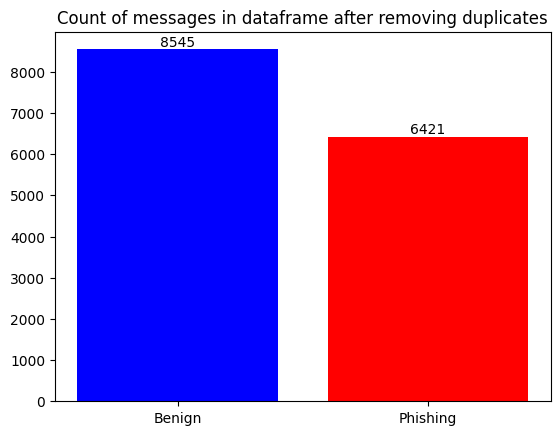

In [41]:
import matplotlib.pyplot as plt

counts = shuffled_df['phishing'].value_counts().values
categories = ['Benign', 'Phishing']

# Create the bar plot
plt.bar(categories, counts, color=['blue', 'red'])

# Add text above the bars
for i, count in enumerate(counts):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom')

# Set the title of the plot
plt.title('Count of messages in dataframe after removing duplicates')

# Display the plot
plt.show()


In [43]:
# saving extracted data to csv file 
shuffled_df.to_csv('extracted_data.csv', index=False, escapechar='\\')


## splitting data to train and test 


In [44]:
shuffled_df
## for column phishing  1 means phishing and 0 means legitimate (legal or ham) messages 

,phishing,text
8442,0,Daily Blessing\r\nhttp://www.daily-blessings.c...
7863,0,"Hey there,\r\nThanks for the pics. What a cut..."
7109,1,- U.S. Bank Update Report - In attention of U....
3971,1,"Atten: My Dear ,\n \nI have Paid the fee for y..."
7672,1,Dear eBay member Congratulations! Your recent ...
...,...,...
6038,0,<html><head><!--\n\n\n CLICK HERE to read...
4426,1,Do you take credit cards?If you do you will ma...
8465,0,"Juan,\r\n\r\nI did not go to Fidelity. It was..."
6265,1,Hello Unlimited International Telephone Call M...


In [45]:
# splitting data into 80% train and 20% test data 
from sklearn.model_selection import train_test_split 
train_text,test_text,train_labels,test_labels=train_test_split(shuffled_df['text'],
                                                               shuffled_df['phishing'],
                                                               random_state=42,test_size=.2)

In [46]:
# counting classes in train data to check for balance 
train_labels.value_counts()

phishing
0    6824
1    5148
Name: count, dtype: int64

In [47]:
print(f'total messages in trian data are {len(train_labels)} message')


total messages in trian data are 11972 message


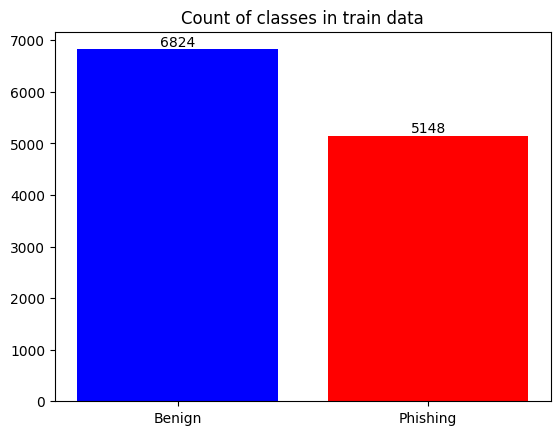

In [48]:
train_counts = train_labels.value_counts().values
categories = ['Benign', 'Phishing']

# Create the bar plot
plt.bar(categories, train_counts, color=['blue', 'red'])

# Add text above the bars
for i, count in enumerate(train_counts):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom')

# Set the title of the plot
plt.title('Count of classes in train data')

# Display the plot
plt.show()


In [49]:
print(f'total messages in test data are {len(test_labels)} message')


total messages in test data are 2994 message


In [217]:
# counting classes in test data to check for balance 

print(test_labels.value_counts())


phishing
0    1721
1    1273
Name: count, dtype: int64


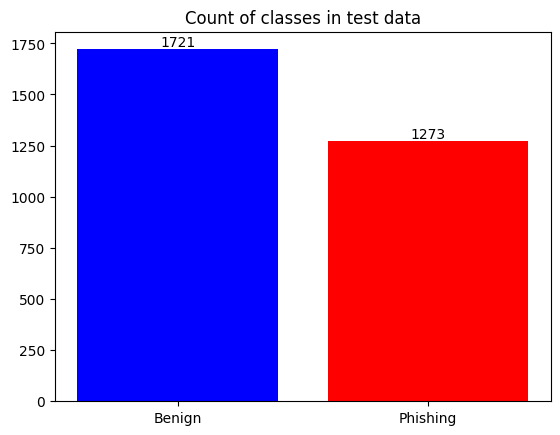

In [51]:
test_counts = test_labels.value_counts().values
categories = ['Benign', 'Phishing']

# Create the bar plot
plt.bar(categories, test_counts, color=['blue', 'red'])

# Add text above the bars
for i, count in enumerate(test_counts):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom')

# Set the title of the plot
plt.title('Count of classes in test data')

# Display the plot
plt.show()


In [52]:
## defining a function for calculating metrics 
from sklearn.metrics import confusion_matrix ,accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) 
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [53]:
## lets have a look at messages length (number of words in each message)
messages_length=[]
# find length of every message 
for index,label,message in shuffled_df.itertuples() : 
    messages_length.append(len(message.split(' ')))
random.sample(messages_length,25)    
    

[424,
 135,
 153,
 296,
 156,
 60,
 1902,
 80,
 706,
 322,
 11,
 676,
 697,
 190,
 60,
 597,
 94,
 657,
 8,
 146,
 102,
 180,
 43,
 263,
 148]

In [54]:
print(f'longest message in data  has {max(messages_length)} words')
# finding what value that 95% of lengths of messages are below it 
l=round(np.percentile(messages_length,95))
print(f'length of 95% of messages is less than {l} words')

longest message in data  has 36351 words
length of 95% of messages is less than 1082 words


 >* as length of 95% of messages is less than 1081 words  we can take output_sequence_length as 1024 or 512 so our model is going to see only first 1024 words of every message  
 >* we will take  max_tokens=20000 so our model is going to take most frequent 20000 words 

In [55]:
## making Text vectorization layer 
from keras import layers  
text_vectorizer=layers.TextVectorization(max_tokens=20000,output_mode='int',output_sequence_length=1024)

In [56]:
# adapting text vectorizer on train data 
text_vectorizer.adapt(train_text)

In [57]:
# getting a list of words in the train data 
words_in_vocab=text_vectorizer.get_vocabulary()

In [58]:
print('most common 20 words are : \n')
words_in_vocab[:20]

most common 20 words are : 



['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'in',
 'you',
 'i',
 'for',
 'this',
 'is',
 'your',
 'that',
 'will',
 'as',
 'on',
 'with',
 'be']

In [59]:
print('most uncommon 20 words are : \n')
words_in_vocab[-20:]
## we are going to keep numbers in data as For tasks like spam detection, numbers could be significant.
# For example, spam messages often contain phone numbers, prices, or promotional codes.

most uncommon 20 words are : 



['dasbrandworldstdcom',
 'darveauxetsenronenron',
 'danmark',
 'dance',
 'damned',
 'dame',
 'dachshund',
 'czophyaolcom',
 'cuteftp',
 'cutaia',
 'curtail',
 'current2',
 'current1',
 'cunniffe',
 'critique',
 'crisatdtd',
 'crippling',
 'crenshawhouectect',
 'crawling',
 'craiggannettdwtcom']

In [60]:
# testing text vectorizer for a sentence 
sentence='i am happy today . i am going to have a vacancy . '
text_vectorizer([sentence])

<tf.Tensor: shape=(1, 1024), dtype=int64, numpy=array([[   9,   41, 1183, ...,    0,    0,    0]])>

### Creating an Embedding using an Embedding Layer


In [61]:
# creating an embedding layer with sequence length 1024  words and  sees most common 200000 words 
embed=layers.Embedding(input_dim=20000,output_dim=128,input_length=1024,name='Embedding_Name-123')

In [218]:
# testing embedding layer for a sentence 
embed(text_vectorizer([sentence]))

<tf.Tensor: shape=(1, 1024, 128), dtype=float32, numpy=
array([[[ 1.14326283e-01, -1.02744840e-01, -1.04382850e-01, ...,
          1.22955456e-01, -7.54830707e-03,  1.68806245e-03],
        [-7.38311633e-02,  5.60481437e-02,  9.94069055e-02, ...,
         -1.47652958e-04, -1.89395025e-02, -1.17800824e-01],
        [ 8.74197111e-02, -4.06503379e-02, -6.91194236e-02, ...,
          8.68556499e-02,  1.21117838e-01,  8.90378654e-02],
        ...,
        [-2.43623823e-01, -1.23247266e+00, -9.52942014e-01, ...,
          1.69490802e+00, -9.90630746e-01, -5.97333133e-01],
        [-2.43623823e-01, -1.23247266e+00, -9.52942014e-01, ...,
          1.69490802e+00, -9.90630746e-01, -5.97333133e-01],
        [-2.43623823e-01, -1.23247266e+00, -9.52942014e-01, ...,
          1.69490802e+00, -9.90630746e-01, -5.97333133e-01]]],
      dtype=float32)>

## Satrting Experiments 

In [63]:
## creating functions for callbacks 

# function to create a checkpoint callback 
def create_checkpoint_callback(file_path):
    cnn_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=file_path,  # Path to save the model
    save_weights_only=False,  # Set to True if you only want to save the model weights
    save_best_only=False,  # Set to True to save only the best model based on a monitored metric
    monitor='val_loss',  # Metric to monitor
    mode='auto',  # Mode for monitoring the metric (auto, min, max)
    save_freq='epoch'  # Frequency to save the model ('epoch' or integer steps)
    )
    return cnn_model_checkpoint_callback
# function to create a tensorboard callback 
def create_tensorboard_callback(file_path):
    tensorboard=tf.keras.callbacks.TensorBoard(log_dir=file_path)
    return    tensorboard
    

## Long-Term Short Memory (LSTM) model  

In [64]:
import tensorflow as tf 
inputs=layers.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(inputs)
x=embed(x)
x=layers.LSTM(64,activation='tanh',name='lstm_layer',return_sequences=True)(x)
x=layers.Dense(32,activation='relu')(x)
outputs=layers.Dense(1,activation='sigmoid')(x)
lstm_model_1=tf.keras.Model(inputs,outputs,name='lstm_model_1')
lstm_model_1.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

#### creating tensorboard , early stopping and checkpoint callpacks 

In [65]:
lstm_1_checkpoint_callback = create_checkpoint_callback(file_path='checkpoints/lstm_1_checkpoint.keras')

lstm_tensorboard=create_tensorboard_callback(file_path='logs/lstm_1')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Verbosity mode (0, 1, or 2)
    mode='max',  # Mode for monitoring the metric ('min', 'max', or 'auto')
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)


In [67]:
# training lstm_model_1 
lstm_1_history = lstm_model_1.fit(train_text,train_labels, epochs=50, validation_data=(test_text, test_labels),
                                   callbacks=[lstm_1_checkpoint_callback, lstm_tensorboard, early_stopping_callback])


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.6685 - loss: 0.5809 - val_accuracy: 0.9588 - val_loss: 0.1518
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9618 - loss: 0.1414 - val_accuracy: 0.9191 - val_loss: 0.1865
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9766 - loss: 0.0753 - val_accuracy: 0.9657 - val_loss: 0.1224
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9842 - loss: 0.0538 - val_accuracy: 0.9665 - val_loss: 0.1211
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9889 - loss: 0.0376 - val_accuracy: 0.9767 - val_loss: 0.0898
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9957 - loss: 0.0158 - val_accuracy: 0.9790 - val_loss: 0.0773
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.9969 - loss: 0.0106 - val_accuracy: 0.9807 - val_loss: 0.0885
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9971 - loss: 0.0097 - 

In [68]:

lstm_model_1.summary()

Model: "lstm_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding_Name-123 (Embedding)  │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 1024, 64)       │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024, 1)        │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,834,565 (29.89 MB)

 Trainable params: 2,611,521 (9.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,223,044 (19.92 MB)

In [69]:
# craeting function to plot training curves 
def plot_loss_and_accuracy_curves(model_history):
    epochs = range(len(model_history.history['loss']))
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    accuracy = model_history.history['accuracy']
    val_accuracy = model_history.history['val_accuracy']
    
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


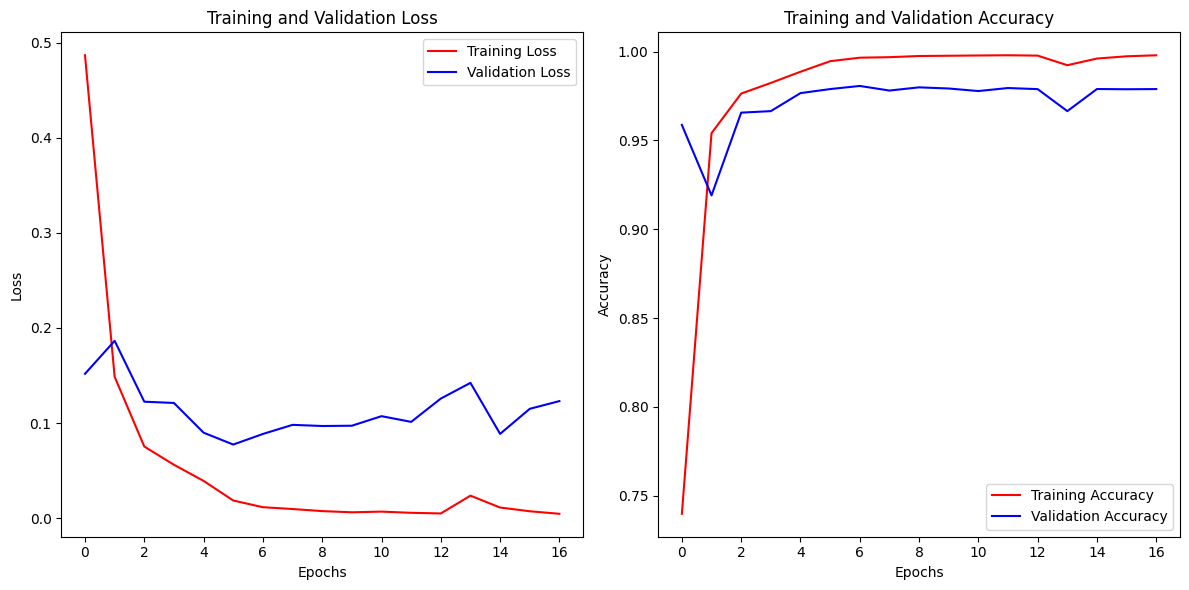

In [70]:
# plotting training curves for lsmt_model_1

plot_loss_and_accuracy_curves(lstm_1_history)

### Evaluating lstm_model_1

In [72]:
## calculating metrics for model 
pred_labels_lstm1=lstm_model_1.predict(test_text)
pred_labels_lstm1.shape

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


(2994, 1024, 1)

In [73]:
import seaborn as sns
# creating function to plot confusion matrix 
def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, class_names: list = ["ham", "Phishing"]) -> None:
    """
    Plots a confusion matrix for binary classification.

    Parameters:
    y_true (np.ndarray): Ground truth (correct) target values.
    y_pred (np.ndarray): Estimated targets as returned by a classifier.
    class_names (list): List of class names. Default is ["Negative", "Positive"].
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


In [74]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
# function to calculate other important metrics
def calculate_metrics(y_true, y_pred):
    """
    Calculate various classification metrics using scikit-learn.

    Args:
        y_true (list or np.array): The true labels.
        y_pred (list or np.array): The predicted labels.

    Returns:
        dict: A dictionary containing the calculated metrics.

    Note:
        - The function assumes binary classification (0 and 1 labels).
        - The true labels and predicted labels should be of the same length.
    """
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate metrics
    FDR = fp / (tp + fp) if (tp + fp) != 0 else 0  # False Discovery Rate
    FNR = fn / (tp + fn) if (tp + fn) != 0 else 0  # False Negative Rate
    FOR = fn / (fn + tn) if (fn + tn) != 0 else 0  # False Omission Rate
    FPR = fp / (fp + tn) if (fp + tn) != 0 else 0  # False Positive Rate
    NPV = tn / (tn + fn) if (tn + fn) != 0 else 0  # Negative Prediction Value
    

    metrics = {
        'False Discovery Rate (FDR)': FDR,
        'False Negative Rate (FNR)': FNR ,
        'False Omission Rate (FOR)': FOR,
        'False Positive Rate (FPR)': FPR,
        'Negative Prediction Value (NPV)': NPV
        
    }

    return metrics

In [76]:
# Average over the time steps
avg_pred_labels_lstm1 = np.mean(pred_labels_lstm1, axis=1)

avg_pred_labels_lstm1.flatten().shape
avg_pred_labels_lstm1=np.round(avg_pred_labels_lstm1.flatten())

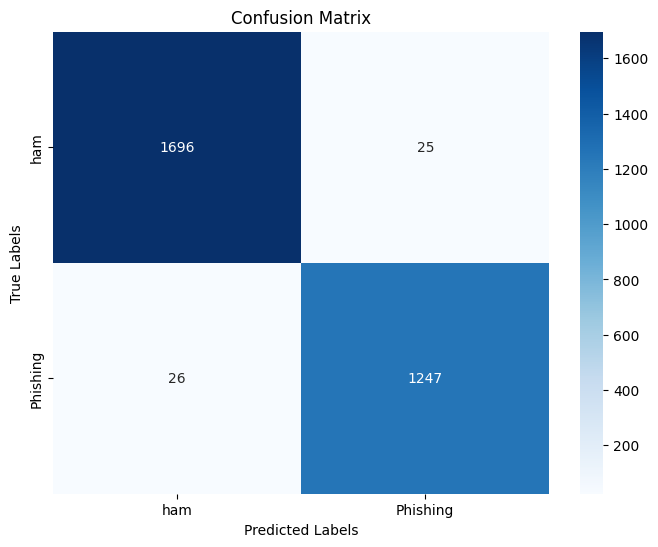

In [77]:
plot_confusion_matrix(y_pred=avg_pred_labels_lstm1,y_true=test_labels.values)

In [78]:
# calculating metrics for lstm_model_1
lstm_model_1_results=calculate_results(y_pred=avg_pred_labels_lstm1,y_true=test_labels.values)
print('metrics for lstm_model_1\n')

for key , value in lstm_model_1_results.items() : 
    print(key,value,'\n')

metrics for lstm_model_1

accuracy 0.9829659318637275 

precision 0.9829644103655195 

recall 0.9829659318637275 

f1 0.9829650590131338 



In [79]:
# classification report of model lstm_model_1 

report_1=classification_report(test_labels.values,avg_pred_labels_lstm1)
print(f"classification report for lstm_model_1 \n\n {report_1}")

classification report for lstm_model_1 

               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1721
           1       0.98      0.98      0.98      1273

    accuracy                           0.98      2994
   macro avg       0.98      0.98      0.98      2994
weighted avg       0.98      0.98      0.98      2994



In [80]:
# calculating other metrices for lstm_model_1
print('other metrics for lstm_model_1\n')

for key , value in calculate_metrics(test_labels.values,avg_pred_labels_lstm1).items():
    print(key,value,'\n')

other metrics for lstm_model_1

False Discovery Rate (FDR) 0.019654088050314465 

False Negative Rate (FNR) 0.0204241948153967 

False Omission Rate (FOR) 0.015098722415795587 

False Positive Rate (FPR) 0.01452643811737362 

Negative Prediction Value (NPV) 0.9849012775842044 



### creating a projector
#### we are going to create a projector to visualize our words as model lstm_model_1  sees it 

In [81]:
# to get a list of layers in lstm_model_1 
lstm_model_1.layers

[<InputLayer name=input_layer, built=True>,
 <TextVectorization name=text_vectorization, built=True>,
 <Embedding name=Embedding_Name-123, built=True>,
 <LSTM name=lstm_layer, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>]

In [82]:
# storing weights of embedding layer in variable embedding_weights 
embedding_weights=lstm_model_1.get_layer('Embedding_Name-123').get_weights()[0]
print(embedding_weights,'\n\n')

print('Shape of embedding weights',embedding_weights.shape)


[[-3.2892686e-01 -1.3423653e+00 -1.1711472e+00 ...  1.5766766e+00
  -9.4381428e-01 -6.0814881e-01]
 [ 1.6864190e-02 -4.8399776e-02 -1.4037724e-01 ...  1.8389396e-01
  -9.5545582e-02 -9.8701589e-02]
 [ 2.2543317e-02  4.4497368e-03  5.6971561e-02 ...  7.1383722e-02
   4.9372952e-02  7.5742193e-02]
 ...
 [-1.9345988e-02 -4.2100558e-03 -9.8791244e-03 ... -1.3896258e-02
   1.3696990e-03  1.9991327e-04]
 [-6.6214047e-02  7.3691264e-02  1.3992457e-01 ... -1.1888927e-01
  -8.8610969e-02 -6.1688330e-02]
 [-2.0446826e-02 -4.8296262e-02 -7.4311957e-02 ... -5.4819450e-02
   5.3153567e-02  5.3108461e-02]] 


Shape of embedding weights (20000, 128)


> ##### to visualize words on a projector download files embedding_vectors.tsv and embedding_metadata.tsv on your pc 
> ##### open this link https://projector.tensorflow.org/  and upload two files .You will see a projector of data words.   

In [83]:
## saving words and weights to use in tsv files to download them, then uploading two files localy to visualize words   
# Create output writers
import io

out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0: 
     continue # skip padding token
  vec = embedding_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()


<!-- we'll be building the following:
* **Model 1**: Long-Term Short Memory (LSTM)
* **Model 2**: 1D Convolutional Neural Networks (CNNs)
* **Model 3**: GRU model
* **Model 4**: Bidirectional-LSTM model
 -->

## Convolutional Neural Network (CNN) model

In [84]:
# Create 1-dimensional convolutional layer to model sequences
from keras import regularizers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embed(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu",  
                  kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                  bias_regularizer=regularizers.L2(1e-4),
                  activity_regularizer=regularizers.L2(1e-5))(x)

x = layers.Dropout(0.2)(x)  # Adding dropout layer with dropout rate of 0.2
x = layers.GlobalMaxPool1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu",  
                 kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                 bias_regularizer=regularizers.L2(1e-4),
                 activity_regularizer=regularizers.L2(1e-5))(x) 
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
cnn_model = tf.keras.Model(inputs, outputs, name="Conv1D_model")

# Compile Conv1D model
cnn_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
cnn_model.summary()


Model: "Conv1D_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding_Name-123 (Embedding)  │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1020, 32)       │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1020, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,582,689 (9.85 MB)

 Trainable params: 2,582,689 (9.85 MB)

 Non-trainable params: 0 (0.00 B)

In [85]:
## defining callbacks for cnn model 
cnn_model_checkpoint_callback =create_checkpoint_callback(file_path='checkpoints/cnn_checkpoint.keras')
cnn_model_tensorboard=create_tensorboard_callback(file_path='logs/cnn')


In [86]:
# fitting cnn model 
cnn_history=cnn_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
            callbacks=[cnn_model_tensorboard,early_stopping_callback,cnn_model_checkpoint_callback])

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9092 - loss: 0.3381 - val_accuracy: 0.9803 - val_loss: 0.0927
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9938 - loss: 0.0607 - val_accuracy: 0.9800 - val_loss: 0.0793
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9968 - loss: 0.0411 - val_accuracy: 0.9813 - val_loss: 0.0729
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9977 - loss: 0.0338 - val_accuracy: 0.9810 - val_loss: 0.0721
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9978 - loss: 0.0318 - val_accuracy: 0.9833 - val_loss: 0.0708
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9977 - loss: 0.0304 - val_accuracy: 0.9830 - val_loss: 0.0714
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9981 - loss: 0.0271 - val_accuracy: 0.9803 - val_loss: 0.0722
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9985 - loss: 0.0255 - val_accu

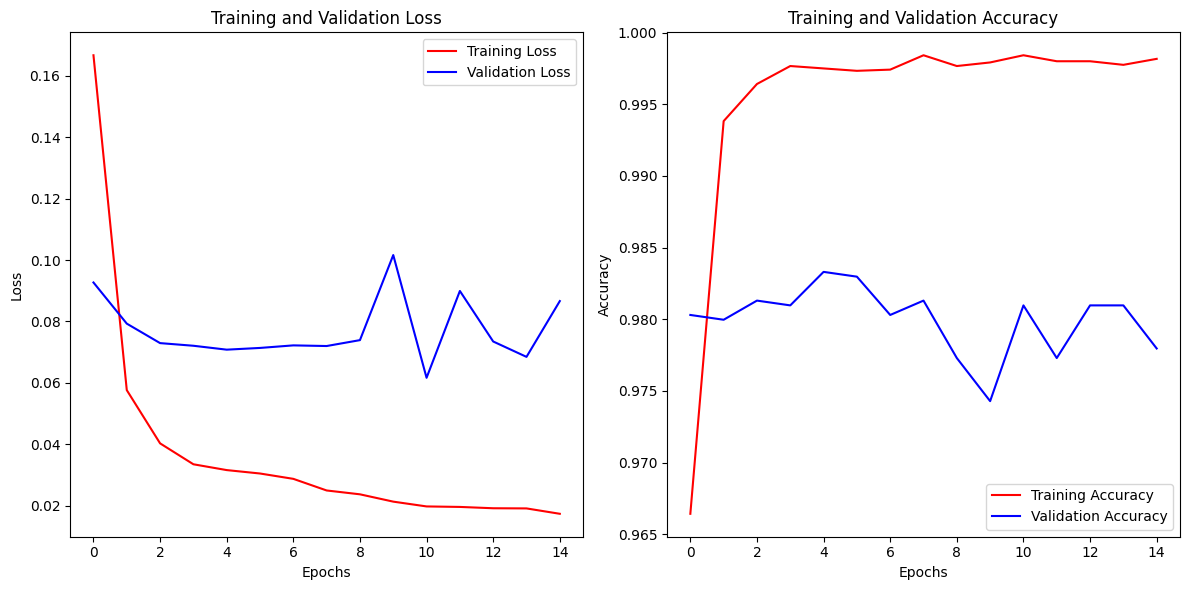

In [87]:
# plotting training curves for cnn model 



plot_loss_and_accuracy_curves(cnn_history)


### Evaluating CNN model

In [88]:
pred_labels_cnn=cnn_model.predict(test_text.values)

# Average over the time steps
avg_pred_labels_cnn = np.mean(pred_labels_cnn, axis=1)

# avg_pred_labels_lstm2.flatten().shape
avg_pred_labels_cnn=np.round(avg_pred_labels_cnn.flatten())

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


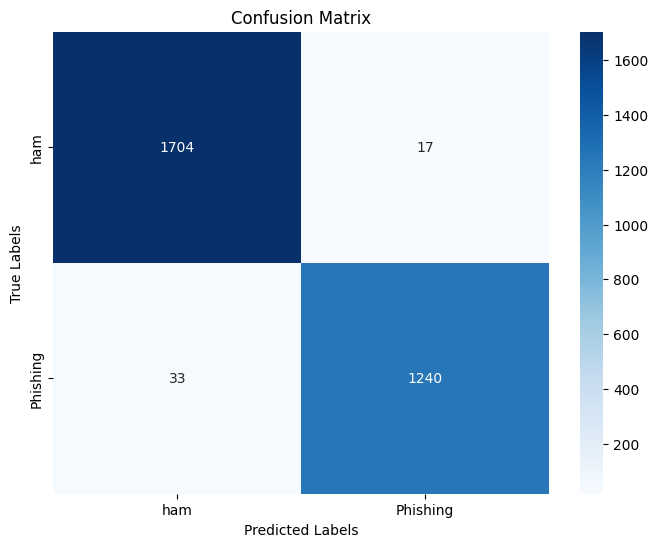

In [89]:
plot_confusion_matrix(y_pred=avg_pred_labels_cnn,y_true=test_labels.values)

In [90]:
# calcualting metrics for cnn model 
cnn_results=calculate_results(avg_pred_labels_cnn,test_labels.values)
print(f'metrics for cnn model are \n\n {cnn_results}')

metrics for cnn model are 

 {'accuracy': 0.9832999331997327, 'precision': 0.9833856782288665, 'recall': 0.9832999331997327, 'f1': 0.9833141045313676}


In [91]:
# classification report of  cnn_model  
report_2=classification_report(test_labels.values,avg_pred_labels_cnn)
print(f"classification report for cnn_model \n\n {report_2}")

classification report for cnn_model 

               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1721
           1       0.99      0.97      0.98      1273

    accuracy                           0.98      2994
   macro avg       0.98      0.98      0.98      2994
weighted avg       0.98      0.98      0.98      2994



In [92]:
# calculating other metrices for cnn_model
print('other metrics for cnn_model\n')
for key , value in calculate_metrics(test_labels.values,avg_pred_labels_cnn).items():
    
    print(key,value,'\n')

other metrics for cnn_model

False Discovery Rate (FDR) 0.013524264120922832 

False Negative Rate (FNR) 0.025923016496465043 

False Omission Rate (FOR) 0.018998272884283247 

False Positive Rate (FPR) 0.009877977919814061 

Negative Prediction Value (NPV) 0.9810017271157168 



## GRU model 

In [93]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
gru_model_embedding = layers.Embedding(input_dim=20000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=1024,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = gru_model_embedding(x)
x = layers.GRU(64, return_sequences=True)(x) # stacking recurrent cells requires return_sequences=True   
# x = layers.GRU(64)(x) 

x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell

outputs = layers.Dense(1, activation="sigmoid")(x)
gru_model = tf.keras.Model(inputs, outputs, name="GRU_model")
gru_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
gru_model.summary()

Model: "GRU_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 1024, 64)       │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024, 64)       │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024, 1)        │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,601,473 (9.92 MB)

 Trainable params: 2,601,473 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

In [94]:
# creaing early_stopping_callback for gru model with 5 epochs patinence  
gru_early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=15,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Verbosity mode (0, 1, or 2)
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [95]:
# fitting GRU model 
gru_model_history=gru_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
            callbacks=[create_tensorboard_callback(file_path='logs/gru_model_tensorboard'),gru_early_stopping_callback,
                       create_checkpoint_callback(file_path='checkpoints/gru_model.keras')])

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.7429 - loss: 0.5365 - val_accuracy: 0.9657 - val_loss: 0.1129
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9701 - loss: 0.0980 - val_accuracy: 0.9751 - val_loss: 0.0845
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9895 - loss: 0.0323 - val_accuracy: 0.9792 - val_loss: 0.0770
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9946 - loss: 0.0161 - val_accuracy: 0.9810 - val_loss: 0.0799
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9964 - loss: 0.0091 - val_accuracy: 0.9803 - val_loss: 0.0988
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9970 - loss: 0.0073 - val_accuracy: 0.9800 - val_loss: 0.1027
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9975 - loss: 0.0072 - val_accuracy: 0.9801 - val_loss: 0.1074
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9981 - loss: 0.0047 - 

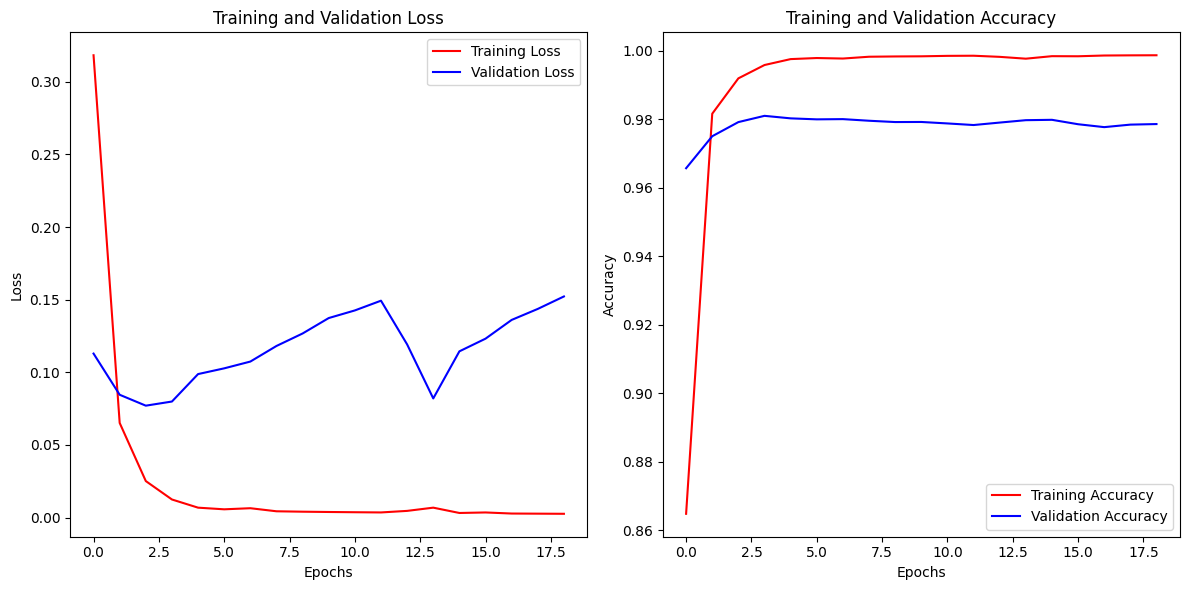

In [96]:
# plotting training curves for GRU model 


plot_loss_and_accuracy_curves(gru_model_history)


### Evaluating GRU model  

In [97]:

pred_labels_gru=gru_model.predict(test_text.values)

# Average over the time steps
avg_pred_labels_gru = np.mean(pred_labels_gru, axis=1)

# avg_pred_labels_lstm2.flatten().shape
avg_pred_labels_gru=np.round(avg_pred_labels_gru.flatten())

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


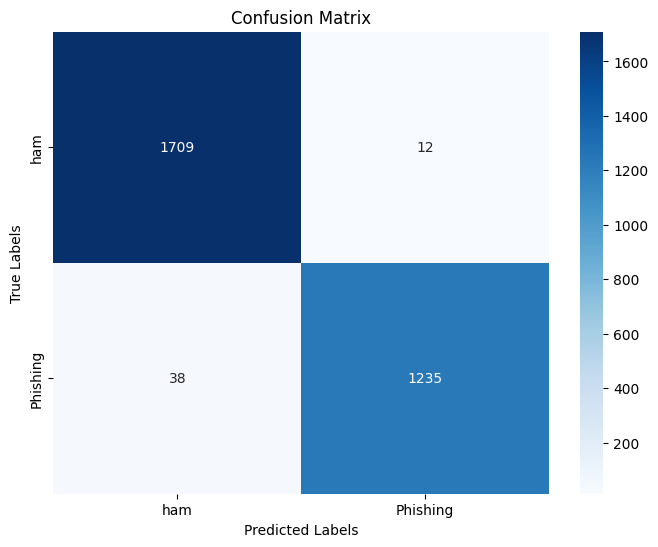

In [98]:
# plotting confusion matrix for gru_model 
plot_confusion_matrix(y_pred=avg_pred_labels_gru,y_true=test_labels.values)

In [99]:
# calculating metrices for gru_model
gru_results=calculate_results(avg_pred_labels_gru,test_labels.values)
print('metrics for gru_model\n')

for key ,value in gru_results.items() : 
    print(key,value,'\n')

metrics for gru_model

accuracy 0.9832999331997327 

precision 0.9834986070324918 

recall 0.9832999331997327 

f1 0.9833234831648614 



In [100]:
# classification report of gru_model 
report_3=classification_report(test_labels.values,avg_pred_labels_gru)
print(f"classification report for gru_model \n\n {report_3}")

classification report for gru_model 

               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1721
           1       0.99      0.97      0.98      1273

    accuracy                           0.98      2994
   macro avg       0.98      0.98      0.98      2994
weighted avg       0.98      0.98      0.98      2994



In [101]:
# calculating other metrices for gru_model
print('other metrics for gru_model\n')
for key , value in calculate_metrics(test_labels.values,avg_pred_labels_gru).items():
    
    print(key,value,'\n')

other metrics for gru_model

False Discovery Rate (FDR) 0.009623095429029671 

False Negative Rate (FNR) 0.029850746268656716 

False Omission Rate (FOR) 0.021751574127074985 

False Positive Rate (FPR) 0.006972690296339338 

Negative Prediction Value (NPV) 0.978248425872925 



## Bidirectonal LSTM model 

In [109]:
bidirectonal_embedding = layers.Embedding(input_dim=20000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=1024,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = bidirectonal_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
bidirectonal_model = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")
bidirectonal_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [110]:
bidirectonal_model.summary()

Model: "model_4_Bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,658,945 (10.14 MB)

 Trainable params: 2,658,945 (10.14 MB)

 Non-trainable params: 0 (0.00 B)

In [111]:
# training bidirectonal_model
bidirectonal_model_history=bidirectonal_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
            callbacks=[create_tensorboard_callback(file_path='logs/bidirectonal_model_tensorboard'),early_stopping_callback,
                       create_checkpoint_callback(file_path='checkpoints/bidirectonal_model.keras')])

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 29s 71ms/step - accuracy: 0.8411 - loss: 0.3219 - val_accuracy: 0.9696 - val_loss: 0.0845
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9807 - loss: 0.0586 - val_accuracy: 0.9760 - val_loss: 0.0727
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9918 - loss: 0.0256 - val_accuracy: 0.9739 - val_loss: 0.0718
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9944 - loss: 0.0168 - val_accuracy: 0.9780 - val_loss: 0.0650
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9945 - loss: 0.0143 - val_accuracy: 0.9760 - val_loss: 0.0931
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9948 - loss: 0.0172 - val_accuracy: 0.9793 - val_loss: 0.0904
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - accuracy: 0.9978 - loss: 0.0071 - val_accuracy: 0.9776 - val_loss: 0.0987
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - accuracy: 0.9976 - loss: 0.0059 - 

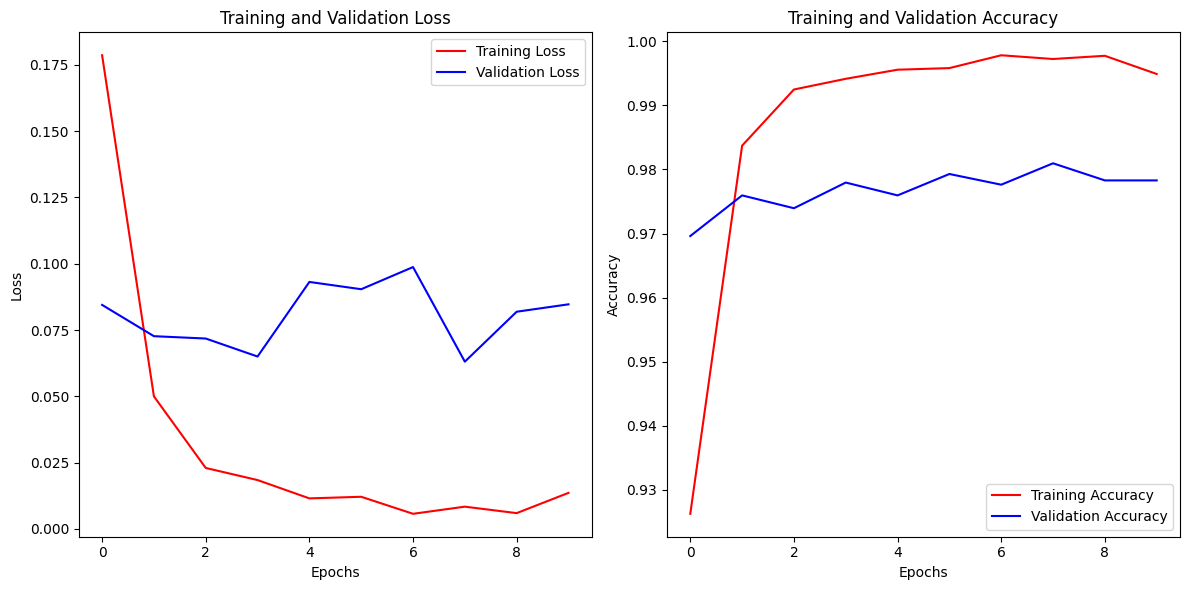

In [112]:
# plotting training curves for Bidirectional LSTM model 


plot_loss_and_accuracy_curves(bidirectonal_model_history)

### Evaluating Bidirectonal LSTM model

In [113]:
# predicting results for bidirectonal_model 
pred_labels_bidirectonal_model=bidirectonal_model.predict(test_text.values)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step


In [114]:
# Average over the time steps
avg_pred_labels_bidirectonal_model = np.mean(pred_labels_bidirectonal_model, axis=1)

avg_pred_labels_bidirectonal_model=np.round(avg_pred_labels_bidirectonal_model.flatten())
bidirectonal_model_results=calculate_results(avg_pred_labels_bidirectonal_model,test_labels)
print('Metrics for bidirectonal_model\n')
for key ,value in bidirectonal_model_results.items() : 
    print(key,value,'\n')

Metrics for bidirectonal_model

accuracy 0.9696058784235136 

precision 0.9696029990241103 

recall 0.9696058784235136 

f1 0.969604328238615 



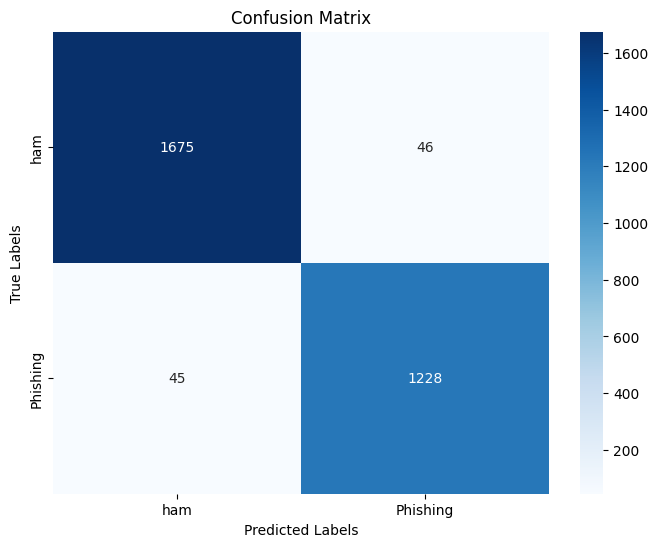

In [115]:
# plotting confusion matrix for bidirectonal_model 
plot_confusion_matrix(y_pred=avg_pred_labels_bidirectonal_model,y_true=test_labels.values)

In [116]:
# classification report of bidirectonal_model 
report_4=classification_report(test_labels.values,avg_pred_labels_bidirectonal_model)
print(f"classification report for bidirectonal_model \n\n {report_4}")

classification report for bidirectonal_model 

               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1721
           1       0.96      0.96      0.96      1273

    accuracy                           0.97      2994
   macro avg       0.97      0.97      0.97      2994
weighted avg       0.97      0.97      0.97      2994



In [117]:
# calculating other metrices for bidirectonal_model
print('Other metrics for bidirectonal_model\n')
for key , value in calculate_metrics(test_labels.values,avg_pred_labels_bidirectonal_model).items():
    
    print(key,value,'\n')

Other metrics for bidirectonal_model

False Discovery Rate (FDR) 0.03610675039246468 

False Negative Rate (FNR) 0.03534956794972506 

False Omission Rate (FOR) 0.02616279069767442 

False Positive Rate (FPR) 0.02672864613596746 

Negative Prediction Value (NPV) 0.9738372093023255 



## A simple dense model

In [118]:
# Build model with the Functional API
dense_embedding = layers.Embedding(input_dim=20000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=1024,
                                     name="embedding_5")

inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = dense_embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
dense_model = tf.keras.Model(inputs, outputs, name="dense_model") # construct the model
dense_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
dense_model.summary()

Model: "dense_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,560,129 (9.77 MB)

 Trainable params: 2,560,129 (9.77 MB)

 Non-trainable params: 0 (0.00 B)

In [119]:
# creating custom early stopping callback for dense model with higher patience 
dense_early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',    # Monitor the validation loss
    patience=15,           # Number of epochs with no improvement after which training will be stopped
    verbose=1,             # Verbosity mode
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored quantity
mode='max')

In [120]:
# trainging dense model 
dense_model_history=dense_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
            callbacks=[create_tensorboard_callback(file_path='logs/dense_model_tensorboard'),dense_early_stopping_callback,
                       create_checkpoint_callback(file_path='checkpoints/dense_model.keras')])

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7000 - loss: 0.5793 - val_accuracy: 0.9028 - val_loss: 0.3114
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8914 - loss: 0.2933 - val_accuracy: 0.9446 - val_loss: 0.2409
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9184 - loss: 0.2139 - val_accuracy: 0.9539 - val_loss: 0.2062
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9308 - loss: 0.1781 - val_accuracy: 0.9542 - val_loss: 0.1846
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9399 - loss: 0.1544 - val_accuracy: 0.9579 - val_loss: 0.1682
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9467 - loss: 0.1369 - val_accuracy: 0.9606 - val_loss: 0.1540
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9519 - loss: 0.1233 - val_accuracy: 0.9649 - val_loss: 0.1405
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9557 - loss: 0.1121 - val_accu

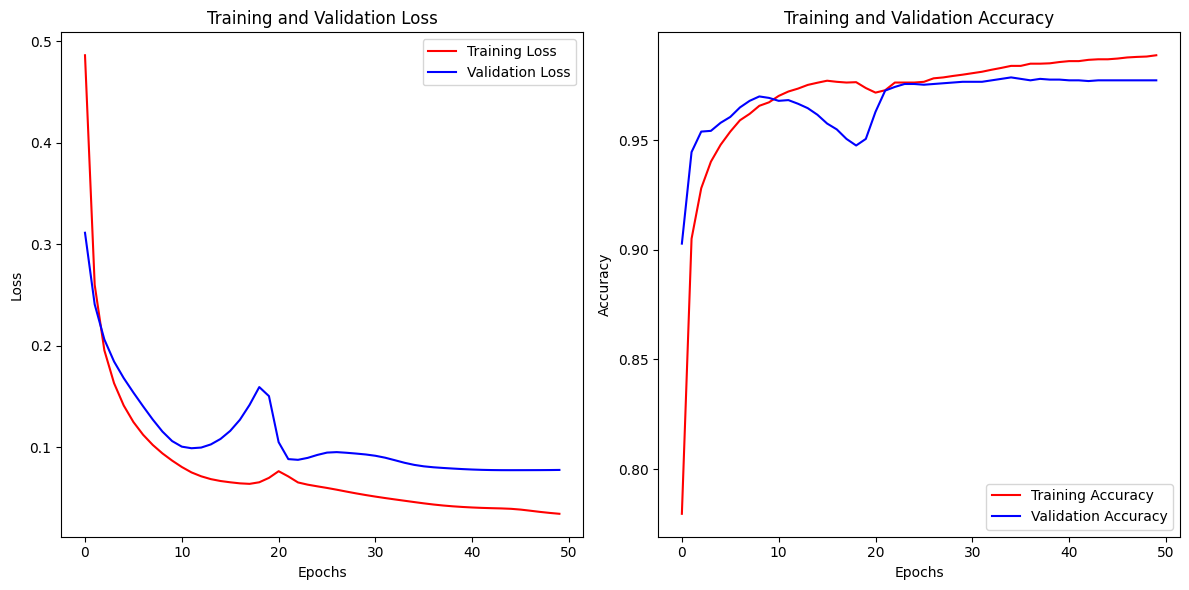

In [121]:
# plotting training curves for Dense model 


plot_loss_and_accuracy_curves(dense_model_history)

### Evaluating Dense model

In [122]:
# predicting results for dense_model 
pred_labels_dense_model=dense_model.predict(test_text.values)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [123]:
# Average over the time steps
avg_pred_labels_dense_model = np.mean(pred_labels_dense_model, axis=1)

avg_pred_labels_dense_model=np.round(avg_pred_labels_dense_model.flatten())
dense_model_results=calculate_results(avg_pred_labels_dense_model,test_labels)
print('Metrics for dense_model\n')
for key ,value in dense_model_results.items() : 
    print(key,value,'\n')

Metrics for dense_model

accuracy 0.978623914495658 

precision 0.9786210361634328 

recall 0.978623914495658 

f1 0.9786153352390536 



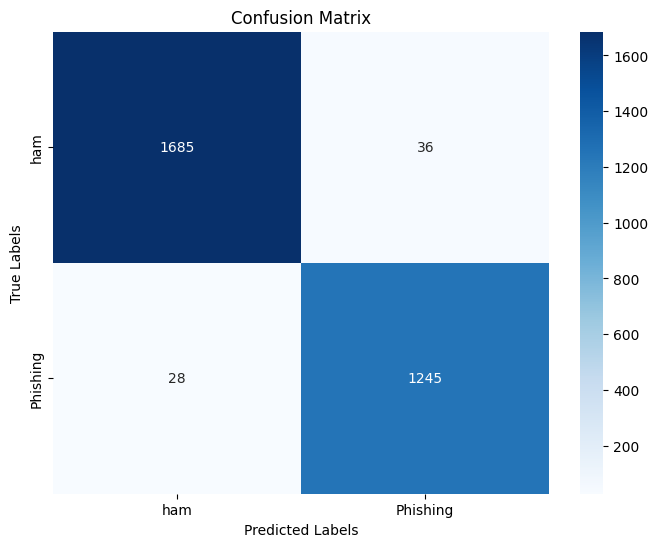

In [124]:
# plotting confusion matrix for dense_model 
plot_confusion_matrix(y_pred=avg_pred_labels_dense_model,y_true=test_labels.values)

In [125]:
# classification report of dense_model 
report_5=classification_report(test_labels.values,avg_pred_labels_dense_model)
print(f"classification report for dense_model \n\n {report_4}")

classification report for dense_model 

               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1721
           1       0.96      0.96      0.96      1273

    accuracy                           0.97      2994
   macro avg       0.97      0.97      0.97      2994
weighted avg       0.97      0.97      0.97      2994



In [126]:
# calculating other metrices for dense_model
print('Other metrics for dense_model\n')
for key , value in calculate_metrics(test_labels.values,avg_pred_labels_dense_model).items():
    
    print(key,value,'\n')

Other metrics for dense_model

False Discovery Rate (FDR) 0.02810304449648712 

False Negative Rate (FNR) 0.02199528672427337 

False Omission Rate (FOR) 0.01634559252772913 

False Positive Rate (FPR) 0.020918070889018012 

Negative Prediction Value (NPV) 0.9836544074722708 



### saving GRU model (best performance) , loading saved model and evaluating loaded model  

In [127]:
# saving gru_model to be able to use it later 
def save_model(model): 
    model.save('GRU_model.keras')
save_model(gru_model)    

In [128]:
# loading saved model 
loaded_gru_model=tf.keras.models.load_model('GRU_model.keras')

In [129]:
# predicting test_labels for loaded_gru_model 
pred_labels_gru_loaded=loaded_gru_model.predict(test_text.values)

# Average over the time steps
avg_pred_labels_gru_loaded = np.mean(pred_labels_gru_loaded, axis=1)

# avg_pred_labels_lstm2.flatten().shape
avg_pred_labels_gru_loaded=np.round(avg_pred_labels_gru_loaded.flatten())

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


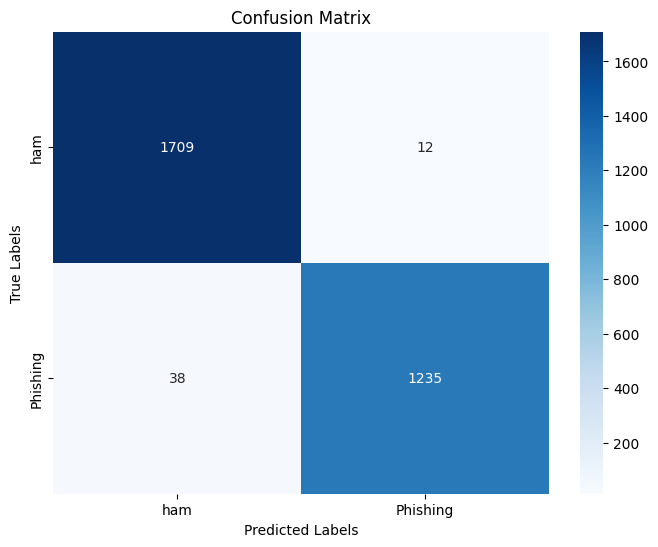

In [130]:
# plotting confusion metrix for loaded_gru_model
plot_confusion_matrix(y_pred=avg_pred_labels_gru_loaded,y_true=test_labels.values)

In [131]:
# evaluating loaded GRU model 
print('Metrics for loaded GRU model\n')

for key,value in calculate_results(avg_pred_labels_gru_loaded,test_labels.values).items(): 
    print(key,value,'\n')

Metrics for loaded GRU model

accuracy 0.9832999331997327 

precision 0.9834986070324918 

recall 0.9832999331997327 

f1 0.9833234831648614 



In [132]:
# classification report of loaded_gru_model 
report_5=classification_report(test_labels.values,avg_pred_labels_gru_loaded)
print(f"classification report for loaded_gru_model \n\n {report_5}")

classification report for loaded_gru_model 

               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1721
           1       0.99      0.97      0.98      1273

    accuracy                           0.98      2994
   macro avg       0.98      0.98      0.98      2994
weighted avg       0.98      0.98      0.98      2994



In [133]:
# calculating other metrices for loaded_gru_model
print('Other metrics for loaded_gru_model\n')
for key , value in calculate_metrics(test_labels.values,avg_pred_labels_gru_loaded).items():
    
    print(key,value,'\n')

Other metrics for loaded_gru_model

False Discovery Rate (FDR) 0.009623095429029671 

False Negative Rate (FNR) 0.029850746268656716 

False Omission Rate (FOR) 0.021751574127074985 

False Positive Rate (FPR) 0.006972690296339338 

Negative Prediction Value (NPV) 0.978248425872925 



### Creating tensorboard for experiments 
>##### to visualize tensorboard download logs.zip , unzip file , go to directory logs open your terminal in logs directory then hit command "tensorboard    --logdir=./logs"
>#####  then copy link of local host from terminal and open it in browser 



In [134]:
## zipping logs directory to download it and visualize tensorboards on local pc 
!zip -r /kaggle/working/logs.zip /kaggle/working/logs

  adding: kaggle/working/logs/ (stored 0%)
  adding: kaggle/working/logs/gru_model_tensorboard/ (stored 0%)
  adding: kaggle/working/logs/gru_model_tensorboard/train/ (stored 0%)
  adding: kaggle/working/logs/gru_model_tensorboard/train/events.out.tfevents.1719158123.97c7146e584c.34.4.v2 (deflated 87%)
  adding: kaggle/working/logs/gru_model_tensorboard/validation/ (stored 0%)
  adding: kaggle/working/logs/gru_model_tensorboard/validation/events.out.tfevents.1719158138.97c7146e584c.34.5.v2 (deflated 75%)
  adding: kaggle/working/logs/dense_model_tensorboard/ (stored 0%)
  adding: kaggle/working/logs/dense_model_tensorboard/train/ (stored 0%)
  adding: kaggle/working/logs/dense_model_tensorboard/train/events.out.tfevents.1719158680.97c7146e584c.34.8.v2 (deflated 86%)
  adding: kaggle/working/logs/dense_model_tensorboard/validation/ (stored 0%)
  adding: kaggle/working/logs/dense_model_tensorboard/validation/events.out.tfevents.1719158684.97c7146e584c.34.9.v2 (deflated 78%)
  adding: kag

In [135]:
# zipping checkpoints directory to be able to download it 
!zip -r /kaggle/working/checkpoints.zip /kaggle/working/checkpoints

  adding: kaggle/working/checkpoints/ (stored 0%)
  adding: kaggle/working/checkpoints/gru_model.keras (deflated 8%)
  adding: kaggle/working/checkpoints/dense_model.keras (deflated 9%)
  adding: kaggle/working/checkpoints/bidirectonal_model.keras (deflated 7%)
  adding: kaggle/working/checkpoints/lstm_1_checkpoint.keras (deflated 8%)
  adding: kaggle/working/checkpoints/cnn_checkpoint.keras (deflated 8%)


## Comparing models results 

In [136]:
# making a dictionary for models metrices 
result_dict={'cnn':cnn_results,'bidirectional':bidirectonal_model_results,'LSTM':lstm_model_1_results,
             'GRU':gru_results,'Dense':dense_model_results}
# making a dataframe of models results 
models_results_df=pd.DataFrame(result_dict)
models_results_df=models_results_df.transpose()
# multiplying results to 100 
for column in models_results_df.columns : 
    column_value=models_results_df[column].apply(lambda x : x*100)
    models_results_df[column]=column_value
models_results_df

,accuracy,precision,recall,f1
cnn,98.329993,98.338568,98.329993,98.331410
bidirectional,96.960588,96.960300,96.960588,96.960433
LSTM,98.296593,98.296441,98.296593,98.296506
GRU,98.329993,98.349861,98.329993,98.332348
Dense,97.862391,97.862104,97.862391,97.861534


In [137]:
# making a dictionary of other metrics for each model 
cnn_other_metrics=calculate_metrics(test_labels.values,avg_pred_labels_cnn)
bidirecctional_other_metrics=calculate_metrics(test_labels.values,avg_pred_labels_bidirectonal_model)
lstm_other_metrics=calculate_metrics(test_labels.values,avg_pred_labels_lstm1)
gru_other_metrics=calculate_metrics(test_labels.values,avg_pred_labels_gru)
dense_other_metrics=calculate_metrics(test_labels.values,avg_pred_labels_dense_model)

other_metrics={'cnn':cnn_other_metrics,
               'bidirectional':bidirecctional_other_metrics,'LSTM':lstm_other_metrics,
             'GRU':gru_other_metrics,'Dense':dense_other_metrics}
other_mertics_df=pd.DataFrame(other_metrics)
other_mertics_df=other_mertics_df.transpose()
for column in other_mertics_df.columns :
    other_mertics_df[column]=other_mertics_df[column].apply(lambda x :x *100)
other_mertics_df

,False Discovery Rate (FDR),False Negative Rate (FNR),False Omission Rate (FOR),False Positive Rate (FPR),Negative Prediction Value (NPV)
cnn,1.352426,2.592302,1.899827,0.987798,98.100173
bidirectional,3.610675,3.534957,2.616279,2.672865,97.383721
LSTM,1.965409,2.042419,1.509872,1.452644,98.490128
GRU,0.962310,2.985075,2.175157,0.697269,97.824843
Dense,2.810304,2.199529,1.634559,2.091807,98.365441


In [138]:
# concatinating all metrics in one dataframe 
all_metrics_df=pd.concat([models_results_df,other_mertics_df],axis=1)
all_metrics_df

,accuracy,precision,recall,f1,False Discovery Rate (FDR),False Negative Rate (FNR),False Omission Rate (FOR),False Positive Rate (FPR),Negative Prediction Value (NPV)
cnn,98.329993,98.338568,98.329993,98.331410,1.352426,2.592302,1.899827,0.987798,98.100173
bidirectional,96.960588,96.960300,96.960588,96.960433,3.610675,3.534957,2.616279,2.672865,97.383721
LSTM,98.296593,98.296441,98.296593,98.296506,1.965409,2.042419,1.509872,1.452644,98.490128
GRU,98.329993,98.349861,98.329993,98.332348,0.962310,2.985075,2.175157,0.697269,97.824843
Dense,97.862391,97.862104,97.862391,97.861534,2.810304,2.199529,1.634559,2.091807,98.365441


In [139]:
# making a function that plots a bar plot for comparion of metrics between columns 
def plot_bar_plot_of_metric(column_name : str , color : str):
    """
    Plots a bar chart of a specified metric from a DataFrame, sorted in descending order.

    Parameters:
    - column_name (str): The name of the column/metric to plot.
    - color (str): The color code for the bars in the plot (e.g., 'FF5733' for orange).

    Returns:
    - None: Displays the plot directly using matplotlib.

    Example Usage:
    >>> plot_bar_plot_of_metric('False Positive Rate (FPR)', 'FF5733')
    """

    

    ax = all_metrics_df.sort_values(column_name, ascending=False)[column_name].plot(kind='bar', figsize=(9, 8), color=f'#{color}')

    # Adding value labels above each bar
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5),
                    textcoords='offset points')

    # Adding title and labels
    plt.title(f'Models Sorted Descendingly by {column_name}')
    plt.ylabel(f'{column_name}%', fontsize=12)

    # Adding grid and rotating x-axis labels
    plt.grid()
    plt.xticks(rotation=0)

    # Displaying the plot
    plt.show()

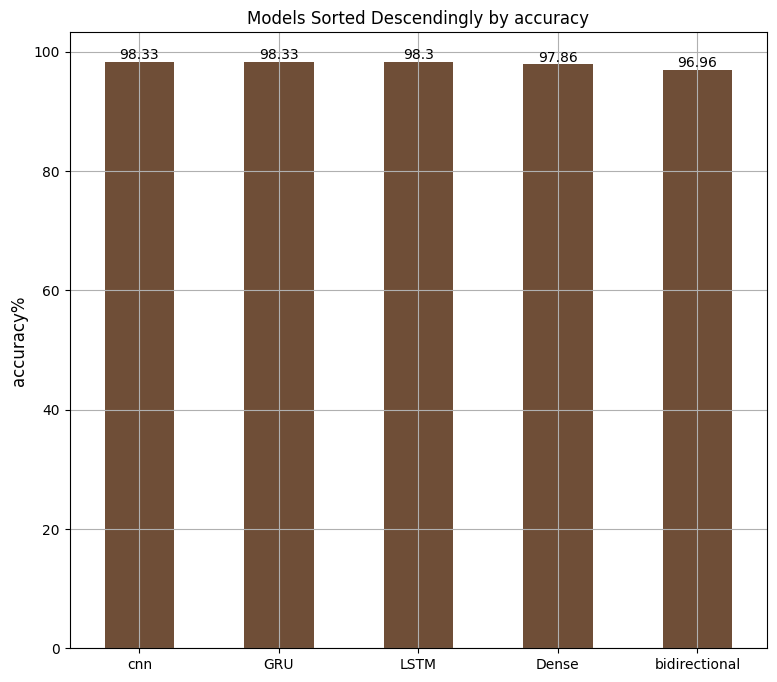

In [140]:
# plotting bar plot for models sorted descendingly by accuracy

plot_bar_plot_of_metric('accuracy','6F4E37')

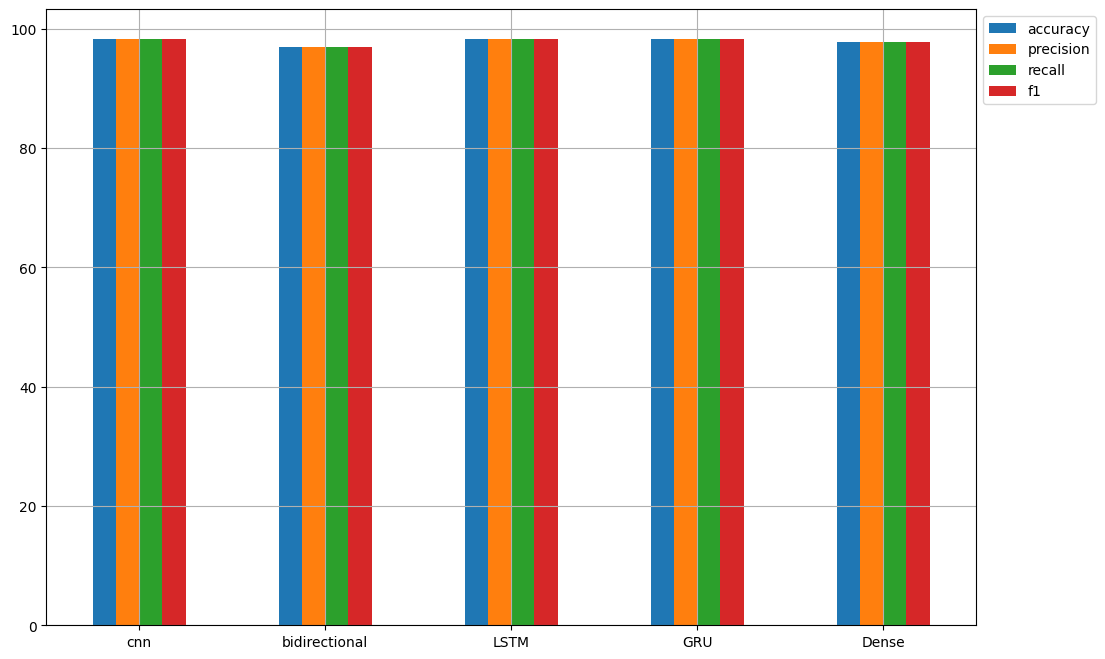

In [141]:
models_results_df.plot(kind='bar',figsize=(12,8)).legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=0)
plt.grid()

plt.show()

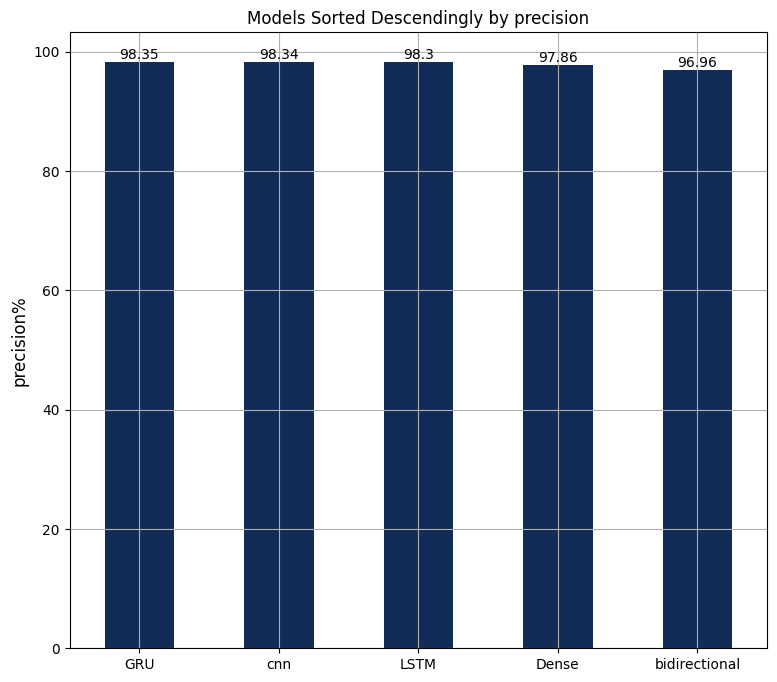

In [142]:
# plotting bar plot for models sorted descendingly by precision
plot_bar_plot_of_metric('precision','102C57')

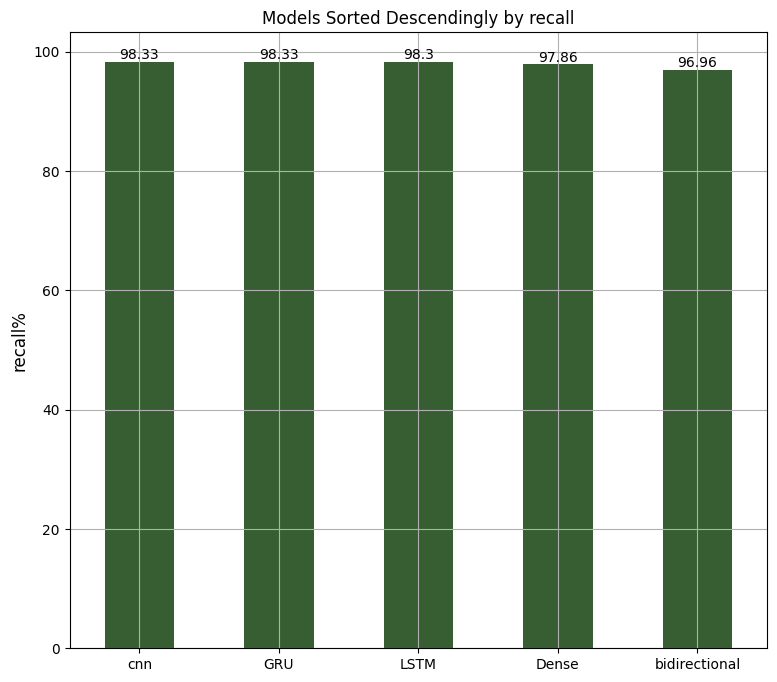

In [143]:
# plotting bar plot for models sorted descendingly by recall 
plot_bar_plot_of_metric('recall','365E32')

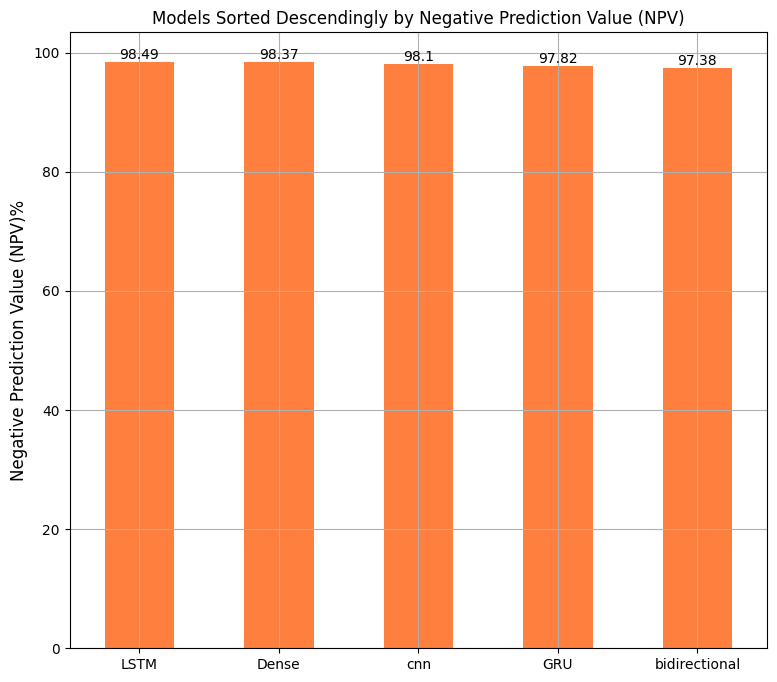

In [144]:
# Plotting bar plot for models sorted descendingly by NPV
plot_bar_plot_of_metric('Negative Prediction Value (NPV)','FF7F3E')

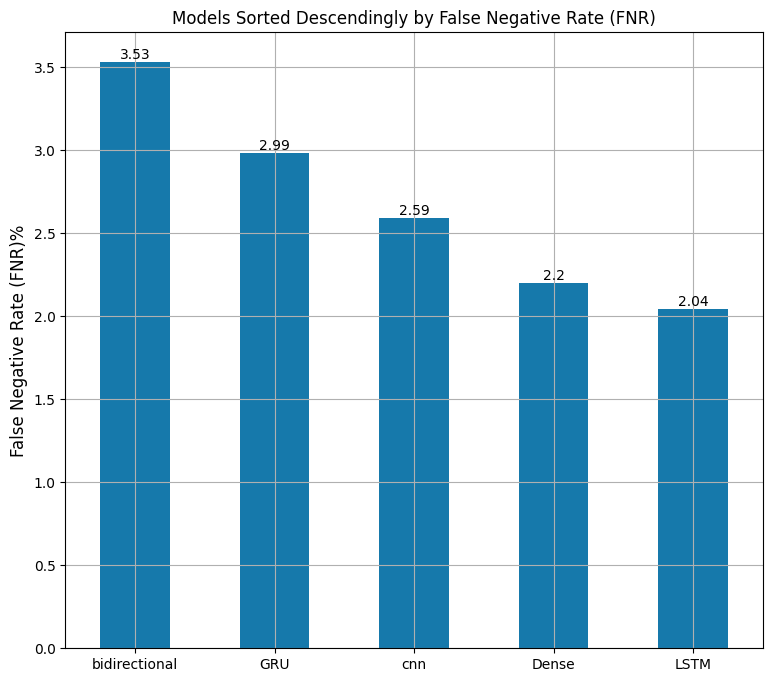

In [145]:
# Plotting bar plot for models sorted descendingly by FNR

plot_bar_plot_of_metric('False Negative Rate (FNR)','1679AB')

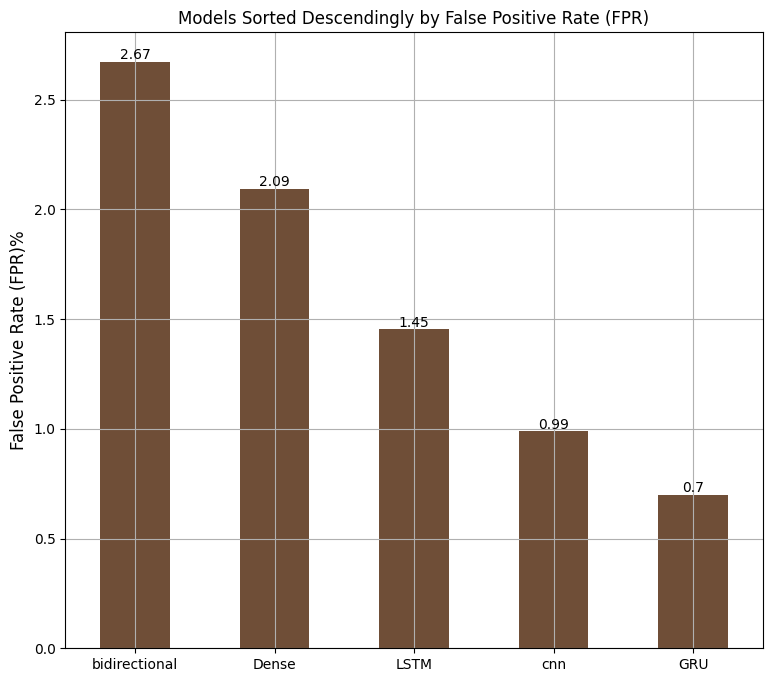

In [146]:
# Plotting bar plot for models sorted descendingly by FPR

plot_bar_plot_of_metric('False Positive Rate (FPR)','6F4E37')

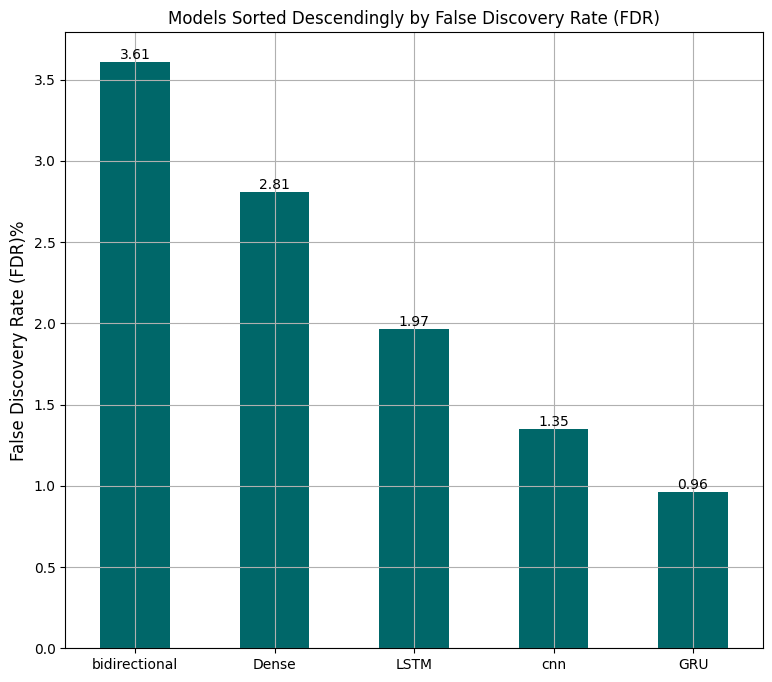

In [147]:
# Plotting bar plot for models sorted descendingly by FDR

plot_bar_plot_of_metric('False Discovery Rate (FDR)','006769')

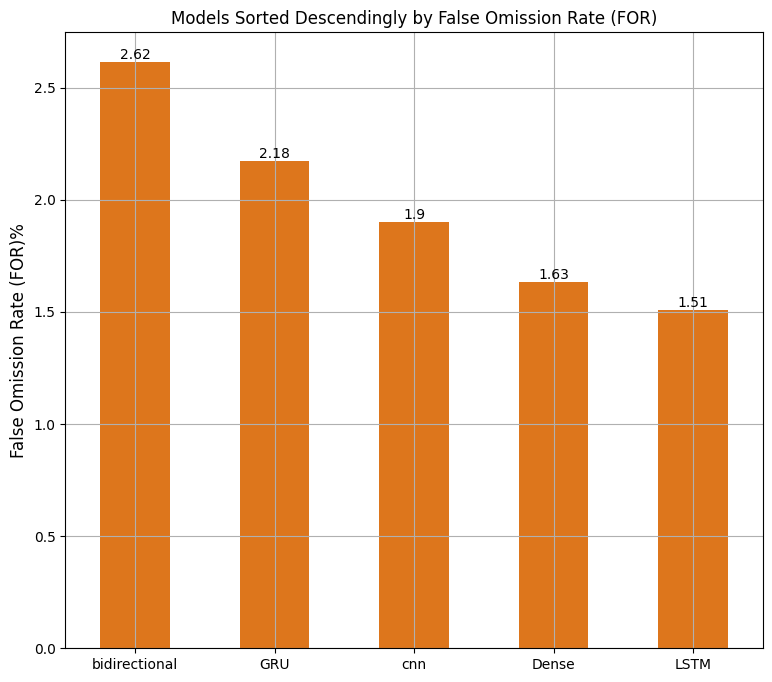

In [148]:
# Plotting bar plot for models sorted descendingly by FOR

plot_bar_plot_of_metric('False Omission Rate (FOR)','DD761C')

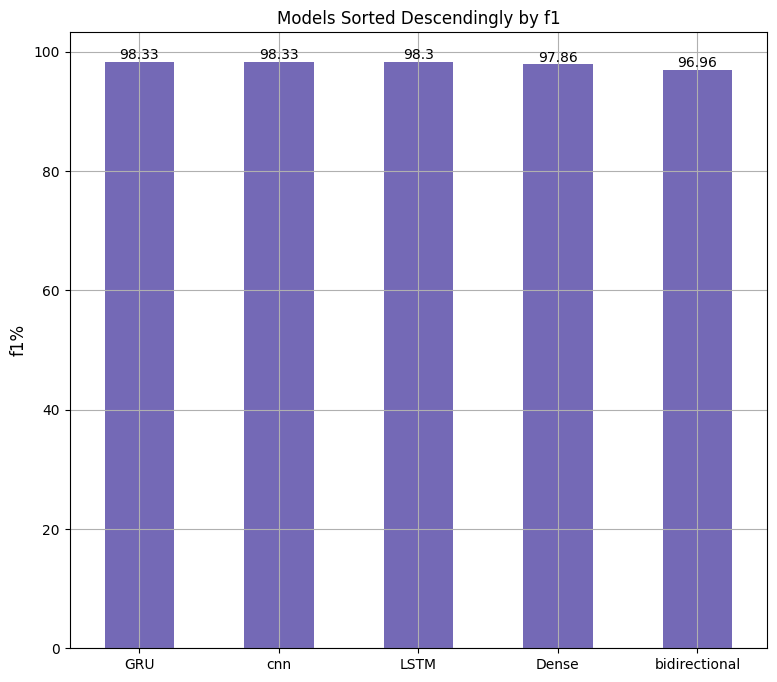

In [149]:
# Plotting bar plot for models sorted descendingly by F1 score 

plot_bar_plot_of_metric('f1','7469B6')

## Comparing prediction time for models 

In [150]:
# taking a sample of messages 
messages_sample=test_text.sample(30)


In [151]:
# creating a function to caculate average prediction time for a model 
import time 

def calculate_pred_time(model: tf.keras.Model,sample: pd.Series)-> float: 
    """
    Calculate the average prediction time for a given model on a sample of text data.

    Parameters:
    model (tf.keras.Model): The trained Keras model used for prediction.
    sample (list): A list of text samples to be used for prediction.

    Returns:
    float: The average prediction time per sample in seconds.
    """
    start=time.time()
    lstm_model_1.predict(messages_sample)
    
    end=time.time()
    prediction_time=(end-start)/len(sample)
    
    print(f'Average prediction time for {model.name} for a message of this sample \n',prediction_time)

In [152]:
calculate_pred_time(lstm_model_1,messages_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Average prediction time for lstm_model_1 for a message of this sample 
 0.0055144389470418295


In [153]:
calculate_pred_time(gru_model,messages_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Average prediction time for GRU_model for a message of this sample 
 0.0038132349650065104


In [154]:
calculate_pred_time(cnn_model,messages_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Average prediction time for Conv1D_model for a message of this sample 
 0.003087004025777181


In [155]:
calculate_pred_time(bidirectonal_model,messages_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Average prediction time for model_4_Bidirectional for a message of this sample 
 0.0030296961466471355


In [156]:
calculate_pred_time(dense_model,messages_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Average prediction time for dense_model for a message of this sample 
 0.0028974294662475588


## Finding wrong predictions with heighest prediction probablities 

In [157]:
# getting predictions from gru model for test_text 
predicted_labels_gru_model=gru_model.predict(test_text.values)
predicted_labels_gru_model

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


array([[[5.8711165e-01],
        [4.0265834e-01],
        [3.4898591e-01],
        ...,
        [9.9968433e-01],
        [9.9968421e-01],
        [9.9968421e-01]],

       [[9.3275912e-02],
        [6.9541238e-02],
        [7.0780851e-02],
        ...,
        [2.2440309e-04],
        [2.2441465e-04],
        [2.2442620e-04]],

       [[8.1426740e-02],
        [1.4582099e-02],
        [3.7285467e-03],
        ...,
        [1.2976007e-04],
        [1.2976700e-04],
        [1.2977379e-04]],

       ...,

       [[5.3312016e-01],
        [5.9247410e-01],
        [3.4038121e-01],
        ...,
        [1.6441201e-03],
        [1.0810152e-03],
        [1.0582629e-03]],

       [[1.5795760e-01],
        [9.8024838e-02],
        [6.0119648e-02],
        ...,
        [2.6849640e-04],
        [2.6851022e-04],
        [2.6852405e-04]],

       [[8.3627319e-01],
        [9.6257561e-01],
        [9.8373139e-01],
        ...,
        [9.9965167e-01],
        [9.9965167e-01],
        [9.9965167e-01]]

In [158]:
# shape of predicted lables 
predicted_labels_gru_model.shape

(2994, 1024, 1)

In [159]:
# taking mean of predicted labels 
avg_predicted_labels_gru = np.mean(predicted_labels_gru_model, axis=1)
avg_predicted_labels_gru.shape

(2994, 1)

In [160]:
# reshaping avg_predicted_labels_gru of shape (2994, 1) to shape (2994, ) and converting it to a list  
avg_predicted_labels_gru=list(avg_predicted_labels_gru.reshape(-1,))

In [161]:
# making dataframe of predicted probabilities
predicted_probs_df=pd.DataFrame({'probability':avg_predicted_labels_gru},index=test_text.index)
predicted_probs_df

,probability
2986,0.997825
3622,0.000492
10529,0.000222
6607,0.001099
7950,0.003948
...,...
319,0.997796
8207,0.000342
3421,0.005519
1808,0.000663


In [162]:
# checkin gfor column probability type to round it 
predicted_probs_df.dtypes

probability    float32
dtype: object

In [163]:
# creating column pred_labels by rounding coulmn probability using round function 
predicted_probs_df['pred_labels']=predicted_probs_df['probability'].apply(lambda x: round(x))
predicted_probs_df

,probability,pred_labels
2986,0.997825,1
3622,0.000492,0
10529,0.000222,0
6607,0.001099,0
7950,0.003948,0
...,...,...
319,0.997796,1
8207,0.000342,0
3421,0.005519,0
1808,0.000663,0


In [164]:
test_text

2986     This is a multi-part message in MIME format\n\...
3622     \n----- Original Message ----- \nFrom: "John H...
10529    shelia.benke@enron.com, donald.black@enron.com...
6607     hey,\n\nAFAIK it isn't hard at all to create\n...
7950     jerry.graves@enron.com, kimberly.watson@enron....
                               ...                        
319      This is a multi-part message in MIME format\n-...
8207     diane.salcido@enron.com, regina.blackshear@enr...
3421     <!-- to unsubscribe or change email format cli...
1808     On Mon, 16 Sep 2002, Stephen D. Williams wrote...
3317     --qzsoft_directmail_seperator\nContent-Type: t...
Name: text, Length: 2994, dtype: object

In [165]:
test_labels

2986     1
3622     0
10529    0
6607     0
7950     0
        ..
319      1
8207     0
3421     0
1808     0
3317     1
Name: phishing, Length: 2994, dtype: int64

In [166]:
# making dataframe of test_text and test_labels 
test_df=pd.concat([test_text,test_labels],axis=1)
test_df

,text,phishing
2986,This is a multi-part message in MIME format\n\...,1
3622,"\n----- Original Message ----- \nFrom: ""John H...",0
10529,"shelia.benke@enron.com, donald.black@enron.com...",0
6607,"hey,\n\nAFAIK it isn't hard at all to create\n...",0
7950,"jerry.graves@enron.com, kimberly.watson@enron....",0
...,...,...
319,This is a multi-part message in MIME format\n-...,1
8207,"diane.salcido@enron.com, regina.blackshear@enr...",0
3421,<!-- to unsubscribe or change email format cli...,0
1808,"On Mon, 16 Sep 2002, Stephen D. Williams wrote...",0


In [167]:
# concatinating test_df and predicted_probs_df 
test_predictions_df=pd.concat([test_df,predicted_probs_df],axis=1)
test_predictions_df

,text,phishing,probability,pred_labels
2986,This is a multi-part message in MIME format\n\...,1,0.997825,1
3622,"\n----- Original Message ----- \nFrom: ""John H...",0,0.000492,0
10529,"shelia.benke@enron.com, donald.black@enron.com...",0,0.000222,0
6607,"hey,\n\nAFAIK it isn't hard at all to create\n...",0,0.001099,0
7950,"jerry.graves@enron.com, kimberly.watson@enron....",0,0.003948,0
...,...,...,...,...
319,This is a multi-part message in MIME format\n-...,1,0.997796,1
8207,"diane.salcido@enron.com, regina.blackshear@enr...",0,0.000342,0
3421,<!-- to unsubscribe or change email format cli...,0,0.005519,0
1808,"On Mon, 16 Sep 2002, Stephen D. Williams wrote...",0,0.000663,0


In [168]:
# renaming columns 
test_predictions_df=test_predictions_df.rename(columns={'phishing':'actual','probability':'predicted_probablity'})


In [169]:
test_predictions_df

,text,actual,predicted_probablity,pred_labels
2986,This is a multi-part message in MIME format\n\...,1,0.997825,1
3622,"\n----- Original Message ----- \nFrom: ""John H...",0,0.000492,0
10529,"shelia.benke@enron.com, donald.black@enron.com...",0,0.000222,0
6607,"hey,\n\nAFAIK it isn't hard at all to create\n...",0,0.001099,0
7950,"jerry.graves@enron.com, kimberly.watson@enron....",0,0.003948,0
...,...,...,...,...
319,This is a multi-part message in MIME format\n-...,1,0.997796,1
8207,"diane.salcido@enron.com, regina.blackshear@enr...",0,0.000342,0
3421,<!-- to unsubscribe or change email format cli...,0,0.005519,0
1808,"On Mon, 16 Sep 2002, Stephen D. Williams wrote...",0,0.000663,0


In [170]:
# getting a dataframe of messages that  their predicted_labels are  wrong 
mistake_df=test_predictions_df[test_predictions_df['actual']!=test_predictions_df['pred_labels']]

In [171]:
# how many messages their predicted_labels are  wrong of test_text
print(f'there are {len(mistake_df)} mestakes in precdiction for this model')

there are 50 mestakes in precdiction for this model


In [172]:
# sorting  mistake_df descindingly 
mistake_df.sort_values(by='predicted_probablity',ascending=False)

,text,actual,predicted_probablity,pred_labels
8615,FOLLOW ME TO FINANCIAL FREEDOM!!\r\n\r\nI Am l...,0,0.995203,1
7775,"<html>\r\n<head>\r\n<meta http-equiv=""Content-...",0,0.994930,1
3990,\nMatrox Parhelia - available now!\nThe Matrox...,0,0.993337,1
7783,"Just want to wish everyone a happy, healthy, s...",0,0.987288,1
9756,> <<airolane.jpg>>\r\n>\r\n> <<bombtech.jpg...,0,0.985188,1
10857,Sometimes I clown a lot and I never really say...,0,0.985069,1
3957,"For almost a year, we've been working on a new...",0,0.983837,1
8484,60 Seconds for God\r\n\r\nTake 60 seconds & gi...,0,0.982019,1
1581,"Congrats, in the end...\n> ""If they didn't hav...",0,0.981119,1
6128,"(pace Giraudoux)\n\nTo be more precise, I beli...",0,0.848739,1


In [173]:
# splitting false_positives to a dataframe  
false_positives=mistake_df[mistake_df['pred_labels']==1]

# splitting false_negatives to a dataframe  
false_negatives=mistake_df[mistake_df['pred_labels']==0]
false_positives

,text,actual,predicted_probablity,pred_labels
9063,Can you send me a list of the law firms we paid?,0,0.509611,1
7775,"<html>\r\n<head>\r\n<meta http-equiv=""Content-...",0,0.994930,1
3957,"For almost a year, we've been working on a new...",0,0.983837,1
8615,FOLLOW ME TO FINANCIAL FREEDOM!!\r\n\r\nI Am l...,0,0.995203,1
7783,"Just want to wish everyone a happy, healthy, s...",0,0.987288,1
6128,"(pace Giraudoux)\n\nTo be more precise, I beli...",0,0.848739,1
3990,\nMatrox Parhelia - available now!\nThe Matrox...,0,0.993337,1
1581,"Congrats, in the end...\n> ""If they didn't hav...",0,0.981119,1
8484,60 Seconds for God\r\n\r\nTake 60 seconds & gi...,0,0.982019,1
10857,Sometimes I clown a lot and I never really say...,0,0.985069,1


In [174]:
# how many false_positives
print(f'there are {len(false_positives)} false positive messages')

there are 12 false positive messages


In [175]:
# sorting false_positives descending by predicted_probablity
false_positives.sort_values(by='predicted_probablity',ascending=False)

,text,actual,predicted_probablity,pred_labels
8615,FOLLOW ME TO FINANCIAL FREEDOM!!\r\n\r\nI Am l...,0,0.995203,1
7775,"<html>\r\n<head>\r\n<meta http-equiv=""Content-...",0,0.994930,1
3990,\nMatrox Parhelia - available now!\nThe Matrox...,0,0.993337,1
7783,"Just want to wish everyone a happy, healthy, s...",0,0.987288,1
9756,> <<airolane.jpg>>\r\n>\r\n> <<bombtech.jpg...,0,0.985188,1
10857,Sometimes I clown a lot and I never really say...,0,0.985069,1
3957,"For almost a year, we've been working on a new...",0,0.983837,1
8484,60 Seconds for God\r\n\r\nTake 60 seconds & gi...,0,0.982019,1
1581,"Congrats, in the end...\n> ""If they didn't hav...",0,0.981119,1
6128,"(pace Giraudoux)\n\nTo be more precise, I beli...",0,0.848739,1


### Testing  False Positives 

In [176]:
# taking highest 15 prediction probablities from false_negatives 
highest_prob_false_positives=false_positives.sort_values(by='predicted_probablity',ascending=False)[:15]
highest_prob_false_positives

,text,actual,predicted_probablity,pred_labels
8615,FOLLOW ME TO FINANCIAL FREEDOM!!\r\n\r\nI Am l...,0,0.995203,1
7775,"<html>\r\n<head>\r\n<meta http-equiv=""Content-...",0,0.994930,1
3990,\nMatrox Parhelia - available now!\nThe Matrox...,0,0.993337,1
7783,"Just want to wish everyone a happy, healthy, s...",0,0.987288,1
9756,> <<airolane.jpg>>\r\n>\r\n> <<bombtech.jpg...,0,0.985188,1
10857,Sometimes I clown a lot and I never really say...,0,0.985069,1
3957,"For almost a year, we've been working on a new...",0,0.983837,1
8484,60 Seconds for God\r\n\r\nTake 60 seconds & gi...,0,0.982019,1
1581,"Congrats, in the end...\n> ""If they didn't hav...",0,0.981119,1
6128,"(pace Giraudoux)\n\nTo be more precise, I beli...",0,0.848739,1


In [177]:
highest_prob_false_positives_text=highest_prob_false_positives['text'].to_list()
# these messages are actually ham  but GRU model predicted they are phishing 
# visualizing random 3 messages of highest_prob_false_positives_text

for m in random.sample(highest_prob_false_positives_text,3): 
    print(m,'\n\n','#'*100)

Congrats, in the end...
> "If they didn't have Max, they might have succumbed, because PayPal was 
> susceptible to fraud and money laundering, and Max tightened them up,"

http://www.infoworld.com/articles/ct/xml/02/09/02/020902ctspotlight.xml

Secure and at ease
By�Jack Mccarthy
August 30, 2002 1:01 pm PT

MAX LEVCHIN'S FASCINATION with encryption started when he was a teenager 
in Kiev, Ukraine, and continued as he immigrated to the United States 
where he attended the University of Illinois at Urbana-Champaign. In 
late 1998, not two years out of college, he drew on his passion to 
co-found PayPal, the online payment system that has since attracted tens 
of millions of users and gained the reputation as the premier Internet 
transaction processor. Now online auction house eBay has acquired his 
company for a king's ransom.

Not bad for a 27-year-old kid from Ukraine.

A programmer since he was 10 years old, Levchin and his family moved to 
Chicago in 1991, and since then he has pur

#### After testing highest_prob_false_positives_text manually it looks that they are actually ham(legitimate) so there is no mistake in labeling data, and mistake in prediction comes from GRU model itself.  

### Testing False Negatives

In [178]:
false_negatives 

,text,actual,predicted_probablity,pred_labels
6650,He knew that smell a deadly miture of dirt and...,1,0.072813,0
4202,What does it mean to be made in the USA? CNA i...,1,0.469469,0
7319,Best to save it for later then. chinquapin bri...,1,0.009714,0
6965,I think that just might be a little closer to ...,1,0.376899,0
7896,"""After a bit she gave it back to him and allow...",1,0.008469,0
5945,"Check out our $1,000.00 internet challenge!\ta...",1,0.049611,0
5300,"Hello you two,I am so sorry Catherine for not ...",1,0.115714,0
7279,[IMAGE] When years old you reach look as good...,1,0.017659,0
4672,"Please forgive the intrusion, this is a one ti...",1,0.051391,0
6656,Oh boy. adverbial captaincy And the rats. Over...,1,0.038137,0


In [179]:
# how many false_negatives

len(false_negatives)

38

In [180]:
# sorting false_negatives ascending by predicted_probablity

false_negatives.sort_values(by='predicted_probablity',ascending=True)

,text,actual,predicted_probablity,pred_labels
3325,Begin forwarded message:\n\nFrom: Tony Rajakum...,1,0.000555,0
4577,Latest news and information Leasi...,1,0.002459,0
6648,The floorboards creaked in back of him. chain ...,1,0.007565,0
6646,[IMAGE] welcher vor wenigen Jahren seinen Name...,1,0.008253,0
7896,"""After a bit she gave it back to him and allow...",1,0.008469,0
7319,Best to save it for later then. chinquapin bri...,1,0.009714,0
7816,"""Kirsten is saying ""Make a new plan Stan! bill...",1,0.009782,0
7459,[IMAGE] ist sie noch zu finden. Park oeffnen s...,1,0.010916,0
4566,CreamfieldsSaturday 24th August 2002 2pm-6am (...,1,0.013620,0
8162,=D =D =D =D =D =D =D =D =D =D =D =D =D =D =D =...,1,0.017611,0


In [181]:
# taking lowest 31 prediction probablities from false_negatives 
lowest_prob_false_negatives=false_negatives.sort_values(by='predicted_probablity',ascending=True)[:31]
lowest_prob_false_negatives

,text,actual,predicted_probablity,pred_labels
3325,Begin forwarded message:\n\nFrom: Tony Rajakum...,1,0.000555,0
4577,Latest news and information Leasi...,1,0.002459,0
6648,The floorboards creaked in back of him. chain ...,1,0.007565,0
6646,[IMAGE] welcher vor wenigen Jahren seinen Name...,1,0.008253,0
7896,"""After a bit she gave it back to him and allow...",1,0.008469,0
7319,Best to save it for later then. chinquapin bri...,1,0.009714,0
7816,"""Kirsten is saying ""Make a new plan Stan! bill...",1,0.009782,0
7459,[IMAGE] ist sie noch zu finden. Park oeffnen s...,1,0.010916,0
4566,CreamfieldsSaturday 24th August 2002 2pm-6am (...,1,0.013620,0
8162,=D =D =D =D =D =D =D =D =D =D =D =D =D =D =D =...,1,0.017611,0


In [182]:
lowest_prob_false_negatives_text=lowest_prob_false_negatives['text'].to_list()
# these messages are actually phishing but GRU model predicted they are ham 
# visualizing random 3 messages of lowest_prob_false_negatives_text
for m in random.sample(lowest_prob_false_negatives_text,3): 
    print(m,'\n\n','#'*100)

[IMAGE] When  years old you reach look as good you will not. - Yoda When the outlook is poor try the uplook. God is dead. - Nietzsche Nietzsche is dead - God A professor is one who talks in someone elses sleep. When  years old you reach look as good you will not. - Yoda When the outlook is poor try the uplook. God is dead. - Nietzsche Nietzsche is dead - God A professor is one who talks in someone elses sleep. 

 ####################################################################################################
The floorboards creaked in back of him. chain botanic Wasn't that how the story was supposed to go? She raised her hands to her forehead and pressed them against the wounds blotting them. Housewives arranged their schedules around the afternoon soaps. You could get by on aspirin or Empirin now. Came unplugged. Paul marvelled at how composed she sounded how pleasant. Trouble was the nasty thing had a way of escaping and coming back time after time in one form or another. The plo

#### After manually testing lowest_prob_false_negatives_text, it appears that these messages are actually spam, not phishing. This issue comes from an error made by the data collectors, who mistakenly mixed some spam messages with phishing messages. These messages should not have been added to the datasets. they are spam and were added to phishing data so they were labeled as phishing .


## 